### This code provides: 

    1) Downloading the raw TNG300-NewSAM data at z=0, 
    2) Choosing only central galaxies 
    3) Removing all galaxies with stellar mass, Mstar<=1e8, 
    4) Calculating the percentage of 0s in each column (feature) and removing the features with mostly 0 entries
    5) Adding logarithmic features, gas fraction and some other relevant ratios
    6) Saving the Raw dataset as is, as well as after removing 23 non-physical galaxies
    7) Looking at correlations of the raw dataset, and raw without non-physical galaxies dataset
    8) Plotting mass-size-spin relation
    9) Normalizing the dataset by dividing all mass features by halo mass, galaxy size by halo size
    10) Removing the not needed features, as well as features used for normalization from the Normalized Dataset
    11) Saving the Normalized Dataset, as well as its version after removing the 23 non-physical galaxies
    12) Looking at correlations of Mbulge-Mstar in Raw vs Normalized the Dataset with and without non-physical galaxies (neede mostly for Serafina's DAG analysis)
    13) Re-defining the Raw and Normalized Datasets without $log_{10}M_{star}$ <9.0 galaxies
    
   
This code is similar to code v36 and v38 for TNG100.

In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together



#### <font color='purple'> [Save the Raw Dataset](#1)
#### <font color='purple'> [Save the Normalized Dataset](#2)
#### <font color='purple'> [Save the Raw Dataset without $log_{10}M_{star}$<9.0 galaxies](#3)
#### <font color='purple'> [Save the Normalized Dataset without $log_{10}M_{star}$<9.0 galaxies](#4)

### Define functions

In [2]:
def log_mass_size(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
#     df=df[(df['GalpropMstar'] > 0) & (df['HalopropMhot'] > 0)]
#     df=df[df['GalpropMbulge'] >= 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df.loc[:,'GalpropLogMstar']=np.log10(df.loc[:,'GalpropMstar'])
    df.loc[:,'GalpropLogHalfRadius']=np.log10(df.loc[:, 'GalpropHalfRadius'])
    df.loc[:,'HalopropLogMvir']=np.log10(df.loc[:,'HalopropMvir'])
    df.loc[:,'HalopropLogMhot']=np.log10(df.loc[:,'HalopropMhot'])
    df.loc[:,'GalpropLogMbulge']=df.loc[:,'GalpropMbulge'].apply(lambda x: np.log10(x) if x>0 else 0)

    return df

In [3]:
def log_SFR(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['sfr'] > 0]

    #since we got rid of all zero mass we can just take the log10
    df['sfr_log']=np.log10(df['sfr'])

    return df

In [4]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [5]:
# function to return the base 10 logarithm of non-zero values
def return_log_SFR(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return -2

In [6]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

### <font color='blue'> Define data frame

In [8]:
# latest version, downloaded on Feb 13, 2023. This is the vdisk, vvir corrected version of Santa Cruz SAM
df=pd.read_hdf('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG_Data_SAM_and_SIM/data/tng300-sam.h5')

In [9]:
# There are a total of 1,183,265 galaxies in the  TNG300-SAM (the one corrected for vdisk)
df

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  \
3         70113.099355  5.334980e+06  8.410620e+07  8.798940e+07   
4         40086.601075  5.297840e+06  1.181020e+08  1.186890e+08   
6         48031.299229  1.542500e+07  2.352650e+08  1.868280e+08   
7        253278.994933  1.498190e+07  2.066300e+08  1.830710e+08   
22        40070.401155  1.809950e+07  2.270450e+08  1.901650e+08   
...                ...           ...           ...           ...   
5985032  389436.987462  2.649780e+07  3.684750e+07  2.741310e+07   
5985270   10019.500223  0.000000e+00  4.336810e-10  2.065750e+06   
5987488   10008.699974  0.000000e+00  0.000000e+00  0.000000e+00   
5987834  824788.003229  1.857910e+06  2.691140e+07  6.153290e+07   
5989436   96398.296591  3.791130e+06  3.562050e+07  3.607350e+07   

         GalpropMaccdot  GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  \
3                   0.0          1.041410e-08   4.956340e+07  2.401300e+08   
4                   0.0          5.833360e-09   4.106860e+07  3.281030e+08   
6                   0.0          6.910570e-09   1.530520e+07  5.911500e+08   
7                   0.0          2.488670e-08   2.456220e+08  5.479110e+08   
22                  0.0          4.324690e-09   1.621790e+07  5.877880e+08   
...                 ...                   ...            ...           ...   
5985032             0.0          4.309700e-08   1.229680e+08  1.175010e+08   
5985270             0.0          1.544280e-09   1.236160e+08  2.791030e+06   
5987488             0.0          0.000000e+00   5.473510e+08  0.000000e+00   
5987834             0.0          5.423410e-08   8.339530e+08  1.219330e+08   
5989436             0.0          7.941590e-09   1.840020e+07  1.022970e+08   

         GalpropMstar  GalpropMstar_merge  GalpropMstrip  GalpropMu_merger  \
3        1.498290e+08        1.260270e+06   2.258640e+10          0.139166   
4        2.677310e+08        1.462520e+06   3.417480e+10          0.123353   
6        1.552730e+08        8.551790e+06   4.377520e+10          0.105218   
7        3.689190e+08        7.245730e+07   5.105800e+10          0.533221   
22       1.770030e+08        3.641170e+06   4.838100e+10          0.349188   
...               ...                 ...            ...               ...   
5985032  5.210760e+08        2.649820e+07   2.581930e+10          0.132893   
5985270  1.255120e+08        0.000000e+00   3.340320e+10          0.000000   
5987488  5.475710e+08        0.000000e+00   4.762650e+09          0.000000   
5987834  8.375820e+08        3.927690e+06   3.513580e+10          0.346080   
5989436  2.393210e+08        2.798690e+06   1.200320e+10          0.000000   

          GalpropMvir  GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  \
3        2.258640e+10                 0.273785                  0.016982   
4        3.417480e+10                 0.524337                  0.032891   
6        4.377520e+10                 0.496575                  0.026464   
7        5.105800e+10                 0.580681                  0.049870   
22       4.838100e+10                 0.384356                  0.027619   
...               ...                      ...                       ...   
5985032  2.581930e+10                 1.220130                  0.113940   
5985270  3.340320e+10                 0.286403                  0.017819   
5987488  9.607320e+09               117.511002                  0.000000   
5987834  3.513580e+10                 0.273052                  0.034979   
5989436  1.200320e+10                 0.285428                  0.019418   

         GalpropRbulge  GalpropRdisk  GalpropRfric  GalpropRhalo  \
3             1.285890      1.489360      0.000000     74.467804   
4             1.609260      1.709830      0.000000     85.491302   
6             2.337160      1.856920      0.000000     92.845901   
7             2.783750      1.954660      0.000000     97.733002   
22            1.426350      1.919880      0.000000     95.994194   


In [10]:
df.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRfric',
 'GalpropRhalo',
 'GalpropSatType',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'GalpropX',
 'GalpropVx',
 'GalpropY',
 'GalpropVy',
 'GalpropZ',
 'GalpropVz',
 'HalopropC_nfw',
 'HalopropMaccdot_metal',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMaccdot_reaccreate_metal',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMdot_eject',
 'HalopropMdot_eject_metal',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMsta

In [11]:
# Rename GalpropR50 as GalpropHalfRadius because that's how it was named in the old SAM (hence all code uses this name)
# Similarly for HalopropMvir -> GalpropMvir. Update(2/10/23): Don't rename HalopropMvir to GalpropMvir because the two are 
# identical for centrals, but not for satellites. Moreover, in the rest of the old SAM analysis I have used
# HalopropMvir to normalize all masses, and not GalpropMvir. However, Ari suggests it would be better to keep
# GalpropMVir for the sake of consistency with the other names for halo properties, like GalpropRhalo, GalpropVvir, etc.
df_new = df.rename(columns={'GalpropHalfmassRadius': 'GalpropHalfRadius'}) #, 'HalopropMvir' : 'GalpropMvir'})
df_new.head(2)

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  GalpropMaccdot  \
3  70113.099355  5.334980e+06  8.410620e+07  8.798940e+07             0.0   
4  40086.601075  5.297840e+06  1.181020e+08  1.186890e+08             0.0   

   GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  GalpropMstar  \
3          1.041410e-08   4.956340e+07  2.401300e+08  1.498290e+08   
4          5.833360e-09   4.106860e+07  3.281030e+08  2.677310e+08   

   GalpropMstar_merge  GalpropMstrip  GalpropMu_merger   GalpropMvir  \
3        1.260270e+06   2.258640e+10          0.139166  2.258640e+10   
4        1.462520e+06   3.417480e+10          0.123353  3.417480e+10   

   GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  GalpropRbulge  \
3                 0.273785                  0.016982        1.28589   
4                 0.524337                  0.032891        1.60926   

   GalpropRdisk  GalpropRfric  GalpropRhalo  GalpropSatType  GalpropSfr  \
3       1.48936           0.0     74.467804             0.0    0.004072   
4       1.70983           0.0     85.491302             0.0    0.009404   

   GalpropSfrave100myr  GalpropSfrave1gyr  GalpropSfrave20myr  \
3             0.003734           0.004101            0.002496   
4             0.008752           0.011879            0.005768   

   GalpropSigmaBulge  GalpropTmerger  GalpropTmerger_major  GalpropTsat  \
3          29.518999        3.092340            113.702003        -99.0   
4          33.430000        0.869185             12.606100        -99.0   

   GalpropVdisk  GalpropZcold  GalpropZstar   GalpropX   GalpropVx  GalpropY  \
3     56.500000      0.014896      0.011260  37.243801  281.679993   15.8553   
4     62.529999      0.020568      0.020358  37.437302  360.320007   15.6441   

    GalpropVy  GalpropZ   GalpropVz  HalopropC_nfw  HalopropMaccdot_metal  \
3 -270.540009   23.5175 -112.489998      30.196501                    0.0   
4 -307.429993   23.5804  -16.270000      31.364300                    0.0   

   HalopropMaccdot_pristine  HalopropMaccdot_radio  \
3                       0.0           1.041410e-08   
4                       0.0           5.833360e-09   

   HalopropMaccdot_reaccreate  HalopropMaccdot_reaccreate_metal  \
3                    0.312146                               0.0   
4                    0.622176                               0.0   

   HalopropMass_ejected  HalopropMcooldot  HalopropMdot_eject  \
3          6.264690e+09      3.124880e+08                 0.0   
4          1.248560e+10      6.242520e+08                 0.0   

   HalopropMdot_eject_metal  HalopropMetal_ejected  HalopropMhot  \
3                       0.0                0.29478   3334.919938   
4                       0.0                0.53540  20187.000700   

   HalopropMstar_diffuse  HalopropMvir  HalopropSpin  HalopropZhot  \
3          315067.009069  2.258640e+10       0.01981    206.850999   
4          814342.987724  3.417480e+10       0.01449    925.469976   

   GalpropVvir  GalpropMdisk  GalpropHalfRadius  
3    36.113822  1.002656e+08           2.172346  
4    41.459710  2.266624e+08           2.727576

In [12]:
# this df contains only central galaxies; features are from TNG300-SAM
df_centrals = df_new[df_new.loc[:, 'GalpropSatType'] == 0]

In [13]:
# There are 813,838  central galaxies in TNG300-SAM 
df_centrals

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  \
3         70113.099355  5.334980e+06  8.410620e+07  8.798940e+07   
4         40086.601075  5.297840e+06  1.181020e+08  1.186890e+08   
6         48031.299229  1.542500e+07  2.352650e+08  1.868280e+08   
7        253278.994933  1.498190e+07  2.066300e+08  1.830710e+08   
22        40070.401155  1.809950e+07  2.270450e+08  1.901650e+08   
...                ...           ...           ...           ...   
5984865   76072.297816  4.980500e+06  3.021450e+08  3.234260e+08   
5985032  389436.987462  2.649780e+07  3.684750e+07  2.741310e+07   
5985270   10019.500223  0.000000e+00  4.336810e-10  2.065750e+06   
5987834  824788.003229  1.857910e+06  2.691140e+07  6.153290e+07   
5989436   96398.296591  3.791130e+06  3.562050e+07  3.607350e+07   

         GalpropMaccdot  GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  \
3                   0.0          1.041410e-08   4.956340e+07  2.401300e+08   
4                   0.0          5.833360e-09   4.106860e+07  3.281030e+08   
6                   0.0          6.910570e-09   1.530520e+07  5.911500e+08   
7                   0.0          2.488670e-08   2.456220e+08  5.479110e+08   
22                  0.0          4.324690e-09   1.621790e+07  5.877880e+08   
...                 ...                   ...            ...           ...   
5984865             0.0          1.737940e-08   7.853430e+07  8.526590e+08   
5985032             0.0          4.309700e-08   1.229680e+08  1.175010e+08   
5985270             0.0          1.544280e-09   1.236160e+08  2.791030e+06   
5987834             0.0          5.423410e-08   8.339530e+08  1.219330e+08   
5989436             0.0          7.941590e-09   1.840020e+07  1.022970e+08   

         GalpropMstar  GalpropMstar_merge  GalpropMstrip  GalpropMu_merger  \
3        1.498290e+08        1.260270e+06   2.258640e+10          0.139166   
4        2.677310e+08        1.462520e+06   3.417480e+10          0.123353   
6        1.552730e+08        8.551790e+06   4.377520e+10          0.105218   
7        3.689190e+08        7.245730e+07   5.105800e+10          0.533221   
22       1.770030e+08        3.641170e+06   4.838100e+10          0.349188   
...               ...                 ...            ...               ...   
5984865  1.039140e+08        7.736300e+06   3.572970e+10          0.683565   
5985032  5.210760e+08        2.649820e+07   2.581930e+10          0.132893   
5985270  1.255120e+08        0.000000e+00   3.340320e+10          0.000000   
5987834  8.375820e+08        3.927690e+06   3.513580e+10          0.346080   
5989436  2.393210e+08        2.798690e+06   1.200320e+10          0.000000   

          GalpropMvir  GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  \
3        2.258640e+10                 0.273785                  0.016982   
4        3.417480e+10                 0.524337                  0.032891   
6        4.377520e+10                 0.496575                  0.026464   
7        5.105800e+10                 0.580681                  0.049870   
22       4.838100e+10                 0.384356                  0.027619   
...               ...                      ...                       ...   
5984865  3.572970e+10                 0.483055                  0.015018   
5985032  2.581930e+10                 1.220130                  0.113940   
5985270  3.340320e+10                 0.286403                  0.017819   
5987834  3.513580e+10                 0.273052                  0.034979   
5989436  1.200320e+10                 0.285428                  0.019418   

         GalpropRbulge  GalpropRdisk  GalpropRfric  GalpropRhalo  \
3             1.285890      1.489360           0.0     74.467804   
4             1.609260      1.709830           0.0     85.491302   
6             2.337160      1.856920           0.0     92.845901   
7             2.783750      1.954660           0.0     97.733002   
22            1.426350      1.919880           0.0     95.994194   


### <font color='blue'> Filter the dataset

In [14]:
# Remove all galaxies with stellar mass log10Mstar<=8 and re-define centrals as such:
df_centrals = df_centrals.loc[df_centrals['GalpropMstar']>1e8, :]

# 813,838 central galaxies with stellar mass >1e8 (for comparison, there were ~39,000 centrals with Mstar>1e8 in TNG100-NewSAM)

In [15]:
# All centrals in this dataset are already more massive than 1e8 because Ari made the mass cut before uploading the dataset
df_centrals

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  \
3         70113.099355  5.334980e+06  8.410620e+07  8.798940e+07   
4         40086.601075  5.297840e+06  1.181020e+08  1.186890e+08   
6         48031.299229  1.542500e+07  2.352650e+08  1.868280e+08   
7        253278.994933  1.498190e+07  2.066300e+08  1.830710e+08   
22        40070.401155  1.809950e+07  2.270450e+08  1.901650e+08   
...                ...           ...           ...           ...   
5984865   76072.297816  4.980500e+06  3.021450e+08  3.234260e+08   
5985032  389436.987462  2.649780e+07  3.684750e+07  2.741310e+07   
5985270   10019.500223  0.000000e+00  4.336810e-10  2.065750e+06   
5987834  824788.003229  1.857910e+06  2.691140e+07  6.153290e+07   
5989436   96398.296591  3.791130e+06  3.562050e+07  3.607350e+07   

         GalpropMaccdot  GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  \
3                   0.0          1.041410e-08   4.956340e+07  2.401300e+08   
4                   0.0          5.833360e-09   4.106860e+07  3.281030e+08   
6                   0.0          6.910570e-09   1.530520e+07  5.911500e+08   
7                   0.0          2.488670e-08   2.456220e+08  5.479110e+08   
22                  0.0          4.324690e-09   1.621790e+07  5.877880e+08   
...                 ...                   ...            ...           ...   
5984865             0.0          1.737940e-08   7.853430e+07  8.526590e+08   
5985032             0.0          4.309700e-08   1.229680e+08  1.175010e+08   
5985270             0.0          1.544280e-09   1.236160e+08  2.791030e+06   
5987834             0.0          5.423410e-08   8.339530e+08  1.219330e+08   
5989436             0.0          7.941590e-09   1.840020e+07  1.022970e+08   

         GalpropMstar  GalpropMstar_merge  GalpropMstrip  GalpropMu_merger  \
3        1.498290e+08        1.260270e+06   2.258640e+10          0.139166   
4        2.677310e+08        1.462520e+06   3.417480e+10          0.123353   
6        1.552730e+08        8.551790e+06   4.377520e+10          0.105218   
7        3.689190e+08        7.245730e+07   5.105800e+10          0.533221   
22       1.770030e+08        3.641170e+06   4.838100e+10          0.349188   
...               ...                 ...            ...               ...   
5984865  1.039140e+08        7.736300e+06   3.572970e+10          0.683565   
5985032  5.210760e+08        2.649820e+07   2.581930e+10          0.132893   
5985270  1.255120e+08        0.000000e+00   3.340320e+10          0.000000   
5987834  8.375820e+08        3.927690e+06   3.513580e+10          0.346080   
5989436  2.393210e+08        2.798690e+06   1.200320e+10          0.000000   

          GalpropMvir  GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  \
3        2.258640e+10                 0.273785                  0.016982   
4        3.417480e+10                 0.524337                  0.032891   
6        4.377520e+10                 0.496575                  0.026464   
7        5.105800e+10                 0.580681                  0.049870   
22       4.838100e+10                 0.384356                  0.027619   
...               ...                      ...                       ...   
5984865  3.572970e+10                 0.483055                  0.015018   
5985032  2.581930e+10                 1.220130                  0.113940   
5985270  3.340320e+10                 0.286403                  0.017819   
5987834  3.513580e+10                 0.273052                  0.034979   
5989436  1.200320e+10                 0.285428                  0.019418   

         GalpropRbulge  GalpropRdisk  GalpropRfric  GalpropRhalo  \
3             1.285890      1.489360           0.0     74.467804   
4             1.609260      1.709830           0.0     85.491302   
6             2.337160      1.856920           0.0     92.845901   
7             2.783750      1.954660           0.0     97.733002   
22            1.426350      1.919880           0.0     95.994194   


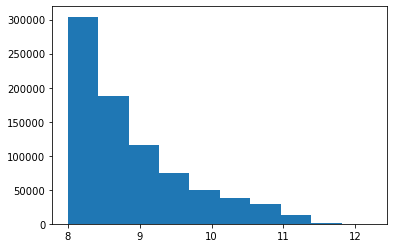

In [16]:
plt.hist(np.log10(df_centrals['GalpropMstar']))
plt.show()

In [17]:
# The distribution of LogMstar in the new SAM
np.log10(df_centrals.GalpropMstar).describe()

count    813838.000000
mean          8.877625
std           0.787767
min           8.000000
25%           8.260608
50%           8.628266
75%           9.283081
max          12.231658
Name: GalpropMstar, dtype: float64

## Add HalopropVvir: halo velocity

In [10]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [19]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_centrals.loc[:,'HalopropMvir']),0) # has units

In [20]:
# add Halo property Vvir
df_centrals.loc[:, 'HalopropVvir']=v.value # shape of df at this point: df_log_mass_filtered.shape (35390, 36)

In [21]:
df_centrals.shape

(813838, 57)

### Calculate the percentage of zeros each column has

In [22]:
# 1) replace 0s with NaN 2) .isnull() gives boolean (whether NaN is true or false)
# 3) .sum() sums the true instances (that is, all 0s in a column)
# 4) dividing by shape[0] divides by the number of total entries (1,346,899) 5) *100 to convert to percentages
100*df_centrals.replace(0, np.nan).isnull().sum()/df.shape[0] 

GalpropMBH                           0.000000
GalpropMH2                           0.307201
GalpropMHI                           0.234436
GalpropMHII                          0.059581
GalpropMaccdot                      68.066663
GalpropMaccdot_radio                 0.000000
GalpropMbulge                        0.365345
GalpropMcold                         0.059496
GalpropMstar                         0.000000
GalpropMstar_merge                   0.395262
GalpropMstrip                        0.000000
GalpropMu_merger                     7.062746
GalpropMvir                          0.000000
GalpropOutflowRate_Mass              0.074201
GalpropOutflowRate_Metal             0.102513
GalpropRbulge                        0.365345
GalpropRdisk                         0.000000
GalpropRfric                        68.779014
GalpropRhalo                         0.000000
GalpropSatType                      68.779014
GalpropSfr                           0.074201
GalpropSfrave100myr               

In [23]:
# calculate the percentage of 0s in each column in order to 1) remove columns of all 0s;
# 2) decide what strategy to use for columns with mostly 0s
df_percentage=pd.DataFrame(100*df_centrals.replace(0, np.nan).isnull().sum()/df_centrals.shape[0] )

In [24]:
df_percentage

0
GalpropMBH                          0.000000
GalpropMH2                          0.446649
GalpropMHI                          0.340854
GalpropMHII                         0.086627
GalpropMaccdot                     98.964290
GalpropMaccdot_radio                0.000000
GalpropMbulge                       0.531187
GalpropMcold                        0.086504
GalpropMstar                        0.000000
GalpropMstar_merge                  0.574684
GalpropMstrip                       0.000000
GalpropMu_merger                   10.268751
GalpropMvir                         0.000000
GalpropOutflowRate_Mass             0.107884
GalpropOutflowRate_Metal            0.149047
GalpropRbulge                       0.531187
GalpropRdisk                        0.000000
GalpropRfric                      100.000000
GalpropRhalo                        0.000000
GalpropSatType                    100.000000
GalpropSfr                          0.107884
GalpropSfrave100myr                 0.106287
GalpropSfrave1gyr                   0.077042
GalpropSfrave20myr                  0.107515
GalpropSigmaBulge                   0.000000
GalpropTmerger                      0.027893
GalpropTmerger_major                0.006389
GalpropTsat                         0.000000
GalpropVdisk                        0.000000
GalpropZcold                        0.062543
GalpropZstar                        0.000000
GalpropX                            0.000000
GalpropVx                           0.001474
GalpropY                            0.000000
GalpropVy                           0.001106
GalpropZ                            0.000000
GalpropVz                           0.001106
HalopropC_nfw                       0.000000
HalopropMaccdot_metal             100.000000
HalopropMaccdot_pristine           53.763403
HalopropMaccdot_radio               0.000000
HalopropMaccdot_reaccreate          0.000000
HalopropMaccdot_reaccreate_metal  100.000000
HalopropMass_ejected                0.000000
HalopropMcooldot                   17.920274
HalopropMdot_eject                100.000000
HalopropMdot_eject_metal          100.000000
HalopropMetal_ejected               0.000000
HalopropMhot                        0.000123
HalopropMstar_diffuse               0.414947
HalopropMvir                        0.000000
HalopropSpin                        0.000000
HalopropZhot                        0.001352
GalpropVvir                         0.000000
GalpropMdisk                        0.000000
GalpropHalfRadius                   0.000000
HalopropVvir                        0.000000

In [25]:
# Save the df with the percentage of 0s of each column
# df_percentage.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_percentage_of_0s_per_column.csv', index=True)

In [26]:
df_centrals['HalopropMaccdot_reaccreate_metal'].value_counts() 

0.0    813838
Name: HalopropMaccdot_reaccreate_metal, dtype: int64

In [27]:
df_centrals['GalpropMaccdot'].value_counts() 

#accretion rate onto black hole; 98% of entries are 0 

0.000000    805409
0.000056         2
0.001065         2
0.002850         2
0.000112         2
             ...  
0.003188         1
0.000046         1
0.001460         1
0.002151         1
0.000238         1
Name: GalpropMaccdot, Length: 8409, dtype: int64

In [28]:
df_centrals['GalpropRfric'].value_counts() 

# distance from halo center , 0 everywhere - because all of them are central galaxies

0.0    813838
Name: GalpropRfric, dtype: int64

In [29]:
# Remove all the columns that are mostly 0s
df_centrals = df_centrals.drop(columns = ['GalpropMaccdot', 'GalpropRfric', 'GalpropSatType',
                                       'HalopropMaccdot_metal', 'HalopropMaccdot_reaccreate_metal',
                                       'HalopropMdot_eject', 'HalopropMdot_eject_metal' ])

In [30]:
df_centrals.shape

(813838, 50)

### Remove other columns like position and 3D velocities

In [31]:
df_centrals = df_centrals.drop(columns = ['GalpropX', 'GalpropVx', 'GalpropY', 'GalpropVy',
                                         'GalpropZ', 'GalpropVz'])

In [32]:
df_centrals.shape

(813838, 44)

### <font color='blue'> Add half_radius by applying half_mass_radius function to each row
    
    The new TNG-SAM dataset already contains the halfmass radius, in feature GalpropR50

These two lines are to compare the lambda x function output with running the half_mass_radius using a for loop.

### <font color='blue'> Logarithmic scale of stellar mass, SFR, Mhalo

In [33]:
df_centrals.shape

(813838, 44)

In [34]:
df_centrals_log=log_mass_size(df_centrals)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
df_centrals_log.head(2)

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  \
3  70113.099355  5.334980e+06  8.410620e+07  8.798940e+07   
4  40086.601075  5.297840e+06  1.181020e+08  1.186890e+08   

   GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  GalpropMstar  \
3          1.041410e-08   4.956340e+07  2.401300e+08  1.498290e+08   
4          5.833360e-09   4.106860e+07  3.281030e+08  2.677310e+08   

   GalpropMstar_merge  GalpropMstrip  GalpropMu_merger   GalpropMvir  \
3        1.260270e+06   2.258640e+10          0.139166  2.258640e+10   
4        1.462520e+06   3.417480e+10          0.123353  3.417480e+10   

   GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  GalpropRbulge  \
3                 0.273785                  0.016982        1.28589   
4                 0.524337                  0.032891        1.60926   

   GalpropRdisk  GalpropRhalo  GalpropSfr  GalpropSfrave100myr  \
3       1.48936     74.467804    0.004072             0.003734   
4       1.70983     85.491302    0.009404             0.008752   

   GalpropSfrave1gyr  GalpropSfrave20myr  GalpropSigmaBulge  GalpropTmerger  \
3           0.004101            0.002496          29.518999        3.092340   
4           0.011879            0.005768          33.430000        0.869185   

   GalpropTmerger_major  GalpropTsat  GalpropVdisk  GalpropZcold  \
3            113.702003        -99.0     56.500000      0.014896   
4             12.606100        -99.0     62.529999      0.020568   

   GalpropZstar  HalopropC_nfw  HalopropMaccdot_pristine  \
3      0.011260      30.196501                       0.0   
4      0.020358      31.364300                       0.0   

   HalopropMaccdot_radio  HalopropMaccdot_reaccreate  HalopropMass_ejected  \
3           1.041410e-08                    0.312146          6.264690e+09   
4           5.833360e-09                    0.622176          1.248560e+10   

   HalopropMcooldot  HalopropMetal_ejected  HalopropMhot  \
3      3.124880e+08                0.29478   3334.919938   
4      6.242520e+08                0.53540  20187.000700   

   HalopropMstar_diffuse  HalopropMvir  HalopropSpin  HalopropZhot  \
3          315067.009069  2.258640e+10       0.01981    206.850999   
4          814342.987724  3.417480e+10       0.01449    925.469976   

   GalpropVvir  GalpropMdisk  GalpropHalfRadius  HalopropVvir  \
3    36.113822  1.002656e+08           2.172346     36.256929   
4    41.459710  2.266624e+08           2.727576     41.624020   

   GalpropLogMstar  GalpropLogHalfRadius  HalopropLogMvir  HalopropLogMhot  \
3         8.175596              0.336929        10.353847         3.523085   
4         8.427699              0.435777        10.533706         4.305072   

   GalpropLogMbulge  
3          7.695161  
4          7.613510

In [36]:
df_centrals_log.shape

(813838, 49)

In [37]:
df_centrals_log.GalpropLogMbulge.describe()

count    813838.000000
mean          8.018954
std           1.083650
min           0.000000
25%           7.425504
50%           7.838703
75%           8.493613
max          12.216266
Name: GalpropLogMbulge, dtype: float64

In [38]:
df_centrals_log.HalopropLogMvir.describe()

count    813838.000000
mean         11.139482
std           0.508028
min           9.843740
25%          10.807044
50%          11.018879
75%          11.358365
max          15.264324
Name: HalopropLogMvir, dtype: float64

In [39]:
# For central galaxies GalpropMvir=HalopropMvir. However, that is not true for satellite galaxies.
np.round(df_centrals_log['GalpropMvir'],2).equals(np.round(df_centrals_log['HalopropMvir'],2))

True

### Is GalpropVvir=HalopropVvir ??

In [40]:
 np.round(df_centrals_log['GalpropVvir'],2).equals(np.round(df_centrals_log['HalopropVvir'],2))

False

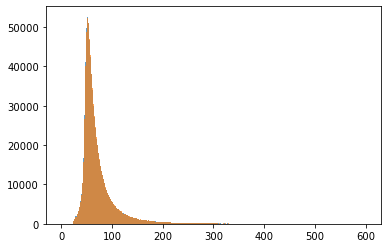

In [41]:
plt.hist(df_centrals_log['GalpropVvir'], alpha=0.7, range=(0,600), bins=300)
plt.hist(df_centrals_log['HalopropVvir'], alpha=0.7, range=(0,600), bins=300)
plt.show()

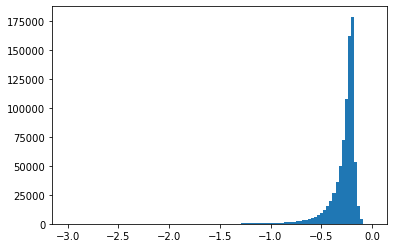

In [42]:
plt.hist(df_centrals_log['GalpropVvir']-df_centrals_log['HalopropVvir'], range=(-3,0), bins=100)
plt.show()

### <font color='red'> Q: GalpropVvir is not exactly the same HalopropVvir.Why? Is this a problem?

In [43]:
df_centrals_log.GalpropLogMstar.describe()

count    813838.000000
mean          8.877625
std           0.787767
min           8.000000
25%           8.260608
50%           8.628266
75%           9.283081
max          12.231658
Name: GalpropLogMstar, dtype: float64

For comparison, the LogMstar statistics for TNG100-NewSAM are:

        count    39257.000000
        mean         8.876416
        std          0.783846
        min          8.000009
        25%          8.259780
        50%          8.627714
        75%          9.287345
        max         12.058126
        Name: GalpropLogMstar, dtype: float64
        
#### That is, thr min and max Mstar are not different in TNG300 from TNG100. The only difference (so far), is that TNG300 has more galaxies.

In [44]:
df_centrals_log.GalpropLogHalfRadius.describe()

count    813838.000000
mean          0.576507
std           0.260404
min          -4.760711
25%           0.483380
50%           0.561242
75%           0.680300
max           2.141215
Name: GalpropLogHalfRadius, dtype: float64

For comparison, the LogHalfRad statistics for TNG100-NewSAM are:

        count    39257.000000
        mean         0.575429
        std          0.263676
        min         -3.005041
        25%          0.481121
        50%          0.561048
        75%          0.682515
        max          1.805620
        Name: GalpropLogHalfRadius, dtype: float64
        
#### That is, the max/min size in TNG300 is bigger/smaller than in TNG100, respectively. 

In [45]:
df_centrals_log.GalpropHalfRadius.describe()

count    813838.000000
mean          4.411919
std           2.913826
min           0.000017
25%           3.043547
50%           3.641181
75%           4.789604
max         138.425129
Name: GalpropHalfRadius, dtype: float64

For comparison, the HalfRad statistics for TNG100-NewSAM are:

        count    39257.000000
        mean         4.407303
        std          2.895038
        min          0.000988
        25%          3.027754
        50%          3.639556
        75%          4.814099
        max         63.917538
        Name: GalpropHalfRadius, dtype: float64
        
#### That is, the max/min size in TNG300 is bigger/smaller than in TNG100, respectively. 

In [11]:
def log_sfr(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR

    '''
    df.loc[:,'GalpropLogSfr']=df.loc[:,'GalpropSfr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave100myr']=df.loc[:,'GalpropSfrave100myr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave1gyr']=df.loc[:,'GalpropSfrave1gyr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave20myr']=df.loc[:,'GalpropSfrave20myr'].apply(lambda x: np.log10(x) if x>0 else 0)

    return df

In [47]:
# add a column with the logarithmic value of SFR, setting any SFR=0 to a fixed value of -2
df_centrals_log = log_sfr(df_centrals_log)

In [48]:
df_centrals_log.head(2)

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  \
3  70113.099355  5.334980e+06  8.410620e+07  8.798940e+07   
4  40086.601075  5.297840e+06  1.181020e+08  1.186890e+08   

   GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  GalpropMstar  \
3          1.041410e-08   4.956340e+07  2.401300e+08  1.498290e+08   
4          5.833360e-09   4.106860e+07  3.281030e+08  2.677310e+08   

   GalpropMstar_merge  GalpropMstrip  GalpropMu_merger   GalpropMvir  \
3        1.260270e+06   2.258640e+10          0.139166  2.258640e+10   
4        1.462520e+06   3.417480e+10          0.123353  3.417480e+10   

   GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  GalpropRbulge  \
3                 0.273785                  0.016982        1.28589   
4                 0.524337                  0.032891        1.60926   

   GalpropRdisk  GalpropRhalo  GalpropSfr  GalpropSfrave100myr  \
3       1.48936     74.467804    0.004072             0.003734   
4       1.70983     85.491302    0.009404             0.008752   

   GalpropSfrave1gyr  GalpropSfrave20myr  GalpropSigmaBulge  GalpropTmerger  \
3           0.004101            0.002496          29.518999        3.092340   
4           0.011879            0.005768          33.430000        0.869185   

   GalpropTmerger_major  GalpropTsat  GalpropVdisk  GalpropZcold  \
3            113.702003        -99.0     56.500000      0.014896   
4             12.606100        -99.0     62.529999      0.020568   

   GalpropZstar  HalopropC_nfw  HalopropMaccdot_pristine  \
3      0.011260      30.196501                       0.0   
4      0.020358      31.364300                       0.0   

   HalopropMaccdot_radio  HalopropMaccdot_reaccreate  HalopropMass_ejected  \
3           1.041410e-08                    0.312146          6.264690e+09   
4           5.833360e-09                    0.622176          1.248560e+10   

   HalopropMcooldot  HalopropMetal_ejected  HalopropMhot  \
3      3.124880e+08                0.29478   3334.919938   
4      6.242520e+08                0.53540  20187.000700   

   HalopropMstar_diffuse  HalopropMvir  HalopropSpin  HalopropZhot  \
3          315067.009069  2.258640e+10       0.01981    206.850999   
4          814342.987724  3.417480e+10       0.01449    925.469976   

   GalpropVvir  GalpropMdisk  GalpropHalfRadius  HalopropVvir  \
3    36.113822  1.002656e+08           2.172346     36.256929   
4    41.459710  2.266624e+08           2.727576     41.624020   

   GalpropLogMstar  GalpropLogHalfRadius  HalopropLogMvir  HalopropLogMhot  \
3         8.175596              0.336929        10.353847         3.523085   
4         8.427699              0.435777        10.533706         4.305072   

   GalpropLogMbulge  GalpropLogSfr  GalpropLogSfrave100myr  \
3          7.695161      -2.390215               -2.427870   
4          7.613510      -2.026706               -2.057871   

   GalpropLogSfrave1gyr  GalpropLogSfrave20myr  
3             -2.387158              -2.602757  
4             -1.925213              -2.238952

In [49]:
df_centrals_log.shape

(813838, 53)

In [50]:
df_centrals_log.GalpropSfr.describe()

count    813838.000000
mean          0.332213
std           1.361929
min           0.000000
25%           0.012676
50%           0.030639
75%           0.125189
max         191.315994
Name: GalpropSfr, dtype: float64

In [51]:
df_centrals_log.GalpropSfrave100myr.describe()

count    813838.000000
mean          0.308858
std           1.309703
min           0.000000
25%           0.012104
50%           0.030167
75%           0.124146
max         289.200012
Name: GalpropSfrave100myr, dtype: float64

### Gas fraction

In [52]:
df_centrals_log.loc[:,'Galprop_neutral_H_mass']=(df_centrals_log.loc[:,'GalpropMHI']+df_centrals_log.loc[:,'GalpropMH2'])
df_centrals_log.loc[:,'Galprop_baryon_mass']=df_centrals_log.loc[:,'Galprop_neutral_H_mass']+df_centrals_log.loc[:,'GalpropMstar']
df_centrals_log.loc[:,'Galprop_gas_fraction']=df_centrals_log.loc[:,'Galprop_neutral_H_mass']/df_centrals_log.loc[:,'Galprop_baryon_mass']

In [53]:
df_centrals_log.loc[: , 'MstarMvir_ratio'] = df_centrals_log.loc[:, 'GalpropMstar']/df_centrals_log.loc[:, 'HalopropMvir']

# Add BulgeMstar ratio and its corresponding quantities (in order to use them in the physical formula)

df_centrals_log.loc[:, 'BulgeMstar_ratio'] = df_centrals_log.loc[:,'GalpropMbulge']/df_centrals_log.loc[:, 'GalpropMstar']
df_centrals_log.loc[:, 'DiskMstar_ratio']  = df_centrals_log.loc[:, 'GalpropMdisk']/df_centrals_log.loc[:, 'GalpropMstar']

In [54]:
df_centrals_log.shape

(813838, 59)

In [55]:
df_centrals_log.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropSpin',
 'HalopropZhot',
 'GalpropVvir',
 'GalpropMdisk',
 'GalpropHalfRadius',
 'HalopropVvir',
 'GalpropLogMstar',
 'GalpropLogHalfRadius',
 'HalopropLogMvir',
 'HalopropLogMhot',
 'GalpropLogMbulge',
 'GalpropL

# <a id =1> </a> <br> Save the raw data set and use it in the next version of the notebook

In [56]:
# df_centrals_log.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1.csv', index=False)

In [57]:
df_centrals_log_v1 = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1.csv') # df here read from the csv in previous line

In [58]:
df_centrals_log_v1.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropSpin',
 'HalopropZhot',
 'GalpropVvir',
 'GalpropMdisk',
 'GalpropHalfRadius',
 'HalopropVvir',
 'GalpropLogMstar',
 'GalpropLogHalfRadius',
 'HalopropLogMvir',
 'HalopropLogMhot',
 'GalpropLogMbulge',
 'GalpropL

In [59]:
# Remove non-physical galaxies whose Mstar/Mvir > 0.2
df_centrals_log_v1_wo_nonphysgals = df_centrals_log_v1[df_centrals_log_v1.MstarMvir_ratio < 0.2]

#There are only 381 non-physical galaxies in the TNG300-NewSAM dataset

In [60]:
df_centrals_log_v1_wo_nonphysgals.shape

(813457, 59)

In [61]:
# df_centrals_log_v1_wo_nonphysgals.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphysgals.csv', index=False)

In [81]:
df_centrals_log_v1_wo_nonphysgals = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphysgals.csv')

In [79]:
df_centrals_log = df_centrals_log_v1.loc[:,:]

NameError: name 'df_centrals_log_v1' is not defined

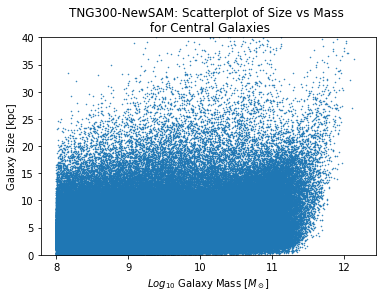

In [63]:
plt.plot(df_centrals_log['GalpropLogMstar'], df_centrals_log['GalpropHalfRadius'], '.', markersize=1)
plt.title('TNG300-NewSAM: Scatterplot of Size vs Mass \n for Central Galaxies')
plt.xlabel('$ Log_{10} $ Galaxy Mass [$ M_\odot $]')
plt.ylabel('Galaxy Size [kpc]')
plt.ylim(0, 40)
# plt.savefig("TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_centrals_size_vs_mass_scatterplot.jpeg", dpi=500)

plt.show()

## <font color='DarkGreen'> Correlations

In [64]:
# HalopropMaccdot_pristine = accretion rate of pristine gas into the halo
df_centrals_log.HalopropMaccdot_pristine.describe()

count    813838.000000
mean          3.579457
std         138.334566
min           0.000000
25%           0.000000
50%           0.000000
75%           0.591298
max       81036.400000
Name: HalopropMaccdot_pristine, dtype: float64

In [65]:
# rate of gas cooling/accretion from halo into ISM
df_centrals_log.HalopropMcooldot.describe()

count    8.138380e+05
mean     2.311845e+09
std      5.048858e+09
min      0.000000e+00
25%      1.694412e+08
50%      5.939080e+08
75%      1.967502e+09
max      6.575480e+10
Name: HalopropMcooldot, dtype: float64

In [66]:
df_pairplot=df_centrals_log.drop(columns =[    'GalpropLogMstar', 'GalpropLogHalfRadius', 'HalopropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction', 'GalpropTsat',
                                               'GalpropVvir'])

In [67]:
df_pairplot.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropMvir', 'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal',
       'GalpropRbulge', 'GalpropRdisk', 'GalpropRhalo', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropSigmaBulge', 'GalpropTmerger', 'GalpropTmerger_major',
       'GalpropVdisk', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropSpin', 'HalopropZhot',
       'GalpropMdisk', 'GalpropHalfRadius', 'HalopropVvir', 'MstarMvir_ratio',
       'BulgeMstar_ratio', 'DiskMstar_rati

In [68]:
df_pairplot.loc[:, 'NormVdisk'] = df_pairplot.loc[:, "GalpropVdisk"]/df_pairplot.loc[:, 'HalopropVvir']
df_pairplot.loc[:,'NormSigmaBulge']=df_pairplot.loc[:,'GalpropSigmaBulge']/df_pairplot.loc[:,'HalopropVvir']

df_pairplot.loc[:, 'NormMbulge']= df_pairplot.loc[:, 'GalpropMbulge']/df_pairplot.loc[:, 'HalopropMvir']

df_pairplot.loc[:, 'NormMdisk']= df_pairplot.loc[:, 'GalpropMdisk']/df_pairplot.loc[:, 'HalopropMvir']

df_pairplot.loc[:, 'NormHalfRadius'] = df_pairplot.loc[:, 'GalpropHalfRadius']/df_pairplot.loc[:, 'GalpropRhalo']

In [69]:
df_pairplot.shape

(813838, 50)

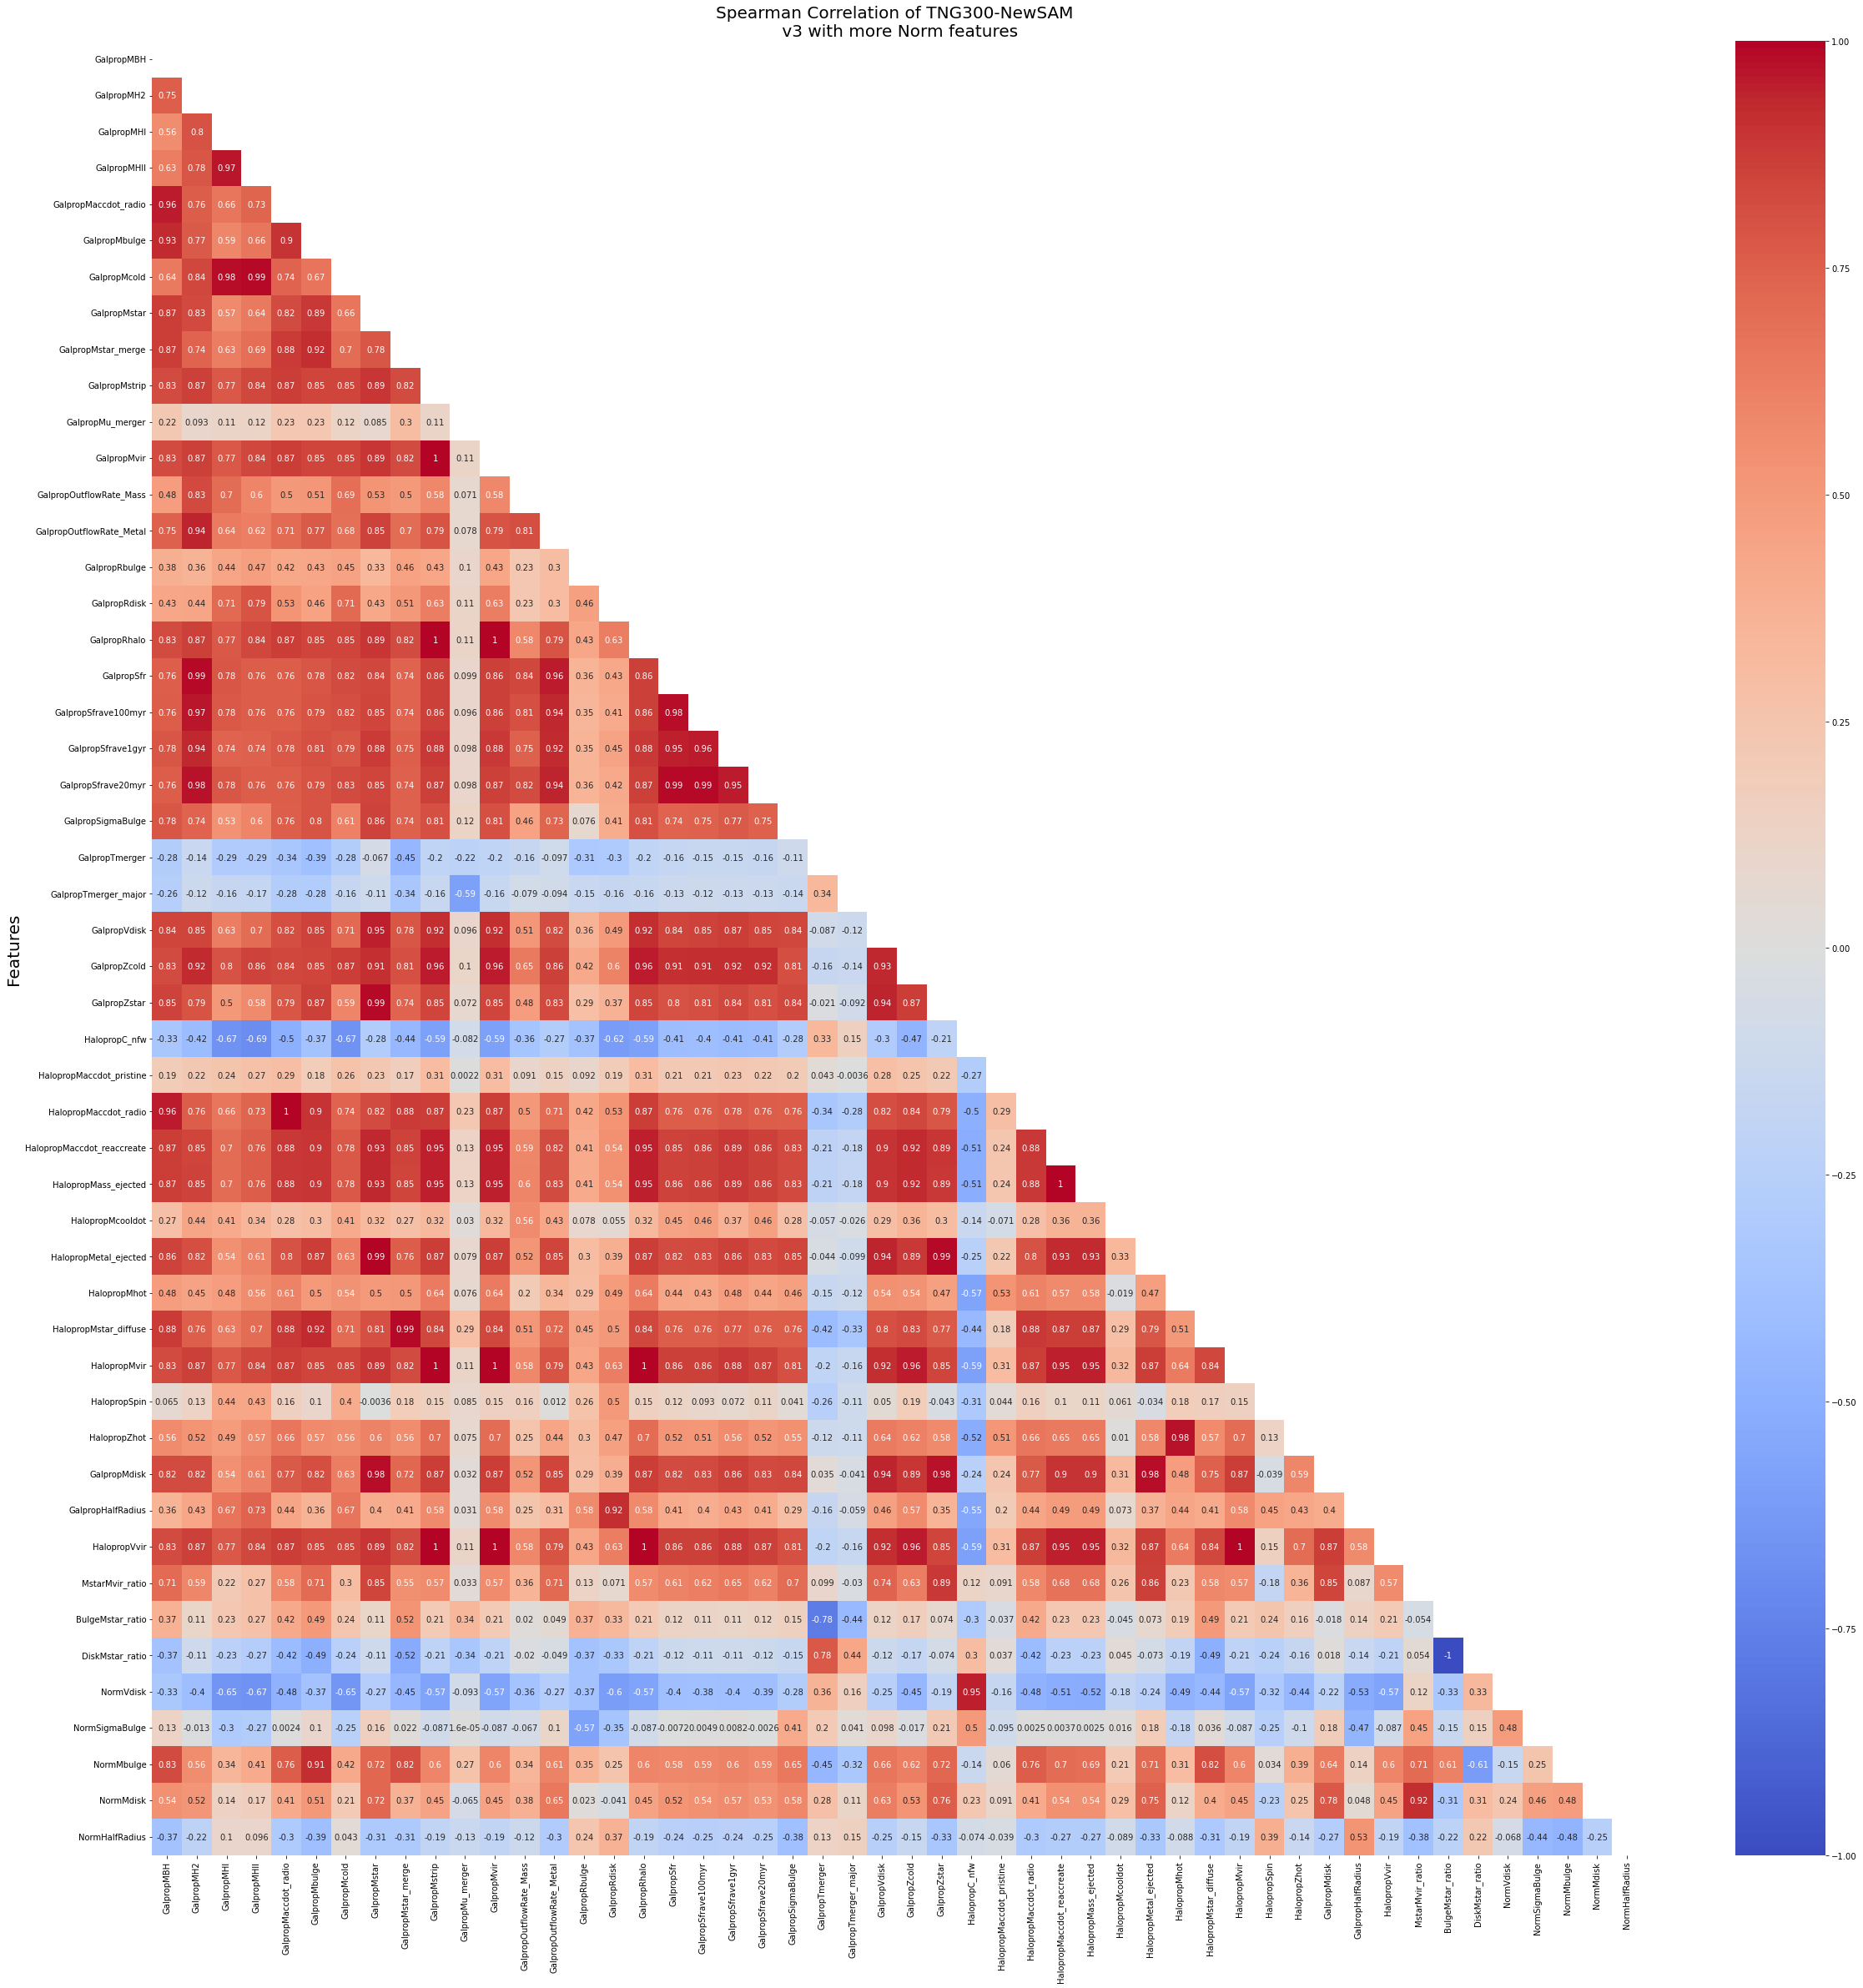

In [71]:
corr_df = df_pairplot.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG300-NewSAM \n v3 with more Norm features", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_Spearman_correlation_matrix_v3withmoreNormfeatures.jpeg', dpi=500)
plt.show()

#### <font color='red'> (Old notes from TNG100) GalpropZcold=metal mass in cold gas is correlated to GalpropVdisk by 0.94. Is this why vdisk becomes important in our physical formula? (Racall Rachel asking why Mcold is not showing up as an important feature).

Mcold is correlated to Zcold by 0.87. 
    
Zcold is correlated to Vvir by 0.96 (is this why it shows up in physical formula where NormVdisk = Vdisk/Vvir and size ~ 1/NormVdisk^2, hence Vvir is in the numerator, just like in the true formula?)
    
Vvir is perfectly correlated to Mstrip (Stripped mass of DM sub-halo), Rhalo and GalpropMvir by 1.0.
    
HalfRadius is correlated to Spin by 0.49 before normalization; it increases to a 0.55 correlation after normalization (NormHalfRadius).
    
NormVdisk is correlated to nothing but Concenctration, where NormVdisk-C_nfw corr=0.95.
    
<font color='red'> Most correlation go away when we use normalized galaxy properties by their corresponding halo properties.
 
<font color='red'> Also, Mdisk/Mstar removes all correlations. The only correlated feature with this one is GalpropTmerger (time since last merger) with corr=0.77.

### <font color='DarkGreen'> Correlations after removing non-physical galaxies with Mstar/Mvir>0.2

In [72]:
df_pairplot2=df_centrals_log.drop(columns =[    'GalpropLogMstar', 'GalpropLogHalfRadius', 'HalopropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction', 'GalpropTsat'])

In [73]:
# Remove non-physical galaxies whose Mstar/Mvir > 0.2
df_pairplot2 = df_pairplot2[df_pairplot2.MstarMvir_ratio < 0.2]

#There are only 23 non-physical galaxies in the TNG100-NewSAM dataset

In [74]:
df_pairplot2.loc[:, 'NormVdisk'] = df_pairplot2.loc[:, "GalpropVdisk"]/df_pairplot2.loc[:, 'HalopropVvir']
df_pairplot2.loc[:,'NormSigmaBulge']=df_pairplot2.loc[:,'GalpropSigmaBulge']/df_pairplot2.loc[:,'HalopropVvir']

df_pairplot2.loc[:, 'NormMbulge']= df_pairplot2.loc[:, 'GalpropMbulge']/df_pairplot2.loc[:, 'HalopropMvir']

df_pairplot2.loc[:, 'NormMdisk']= df_pairplot2.loc[:, 'GalpropMdisk']/df_pairplot2.loc[:, 'HalopropMvir']

df_pairplot2.loc[:, 'NormHalfRadius'] = df_pairplot2.loc[:, 'GalpropHalfRadius']/df_pairplot2.loc[:, 'GalpropRhalo']

In [75]:
df_pairplot2.shape

(813457, 51)

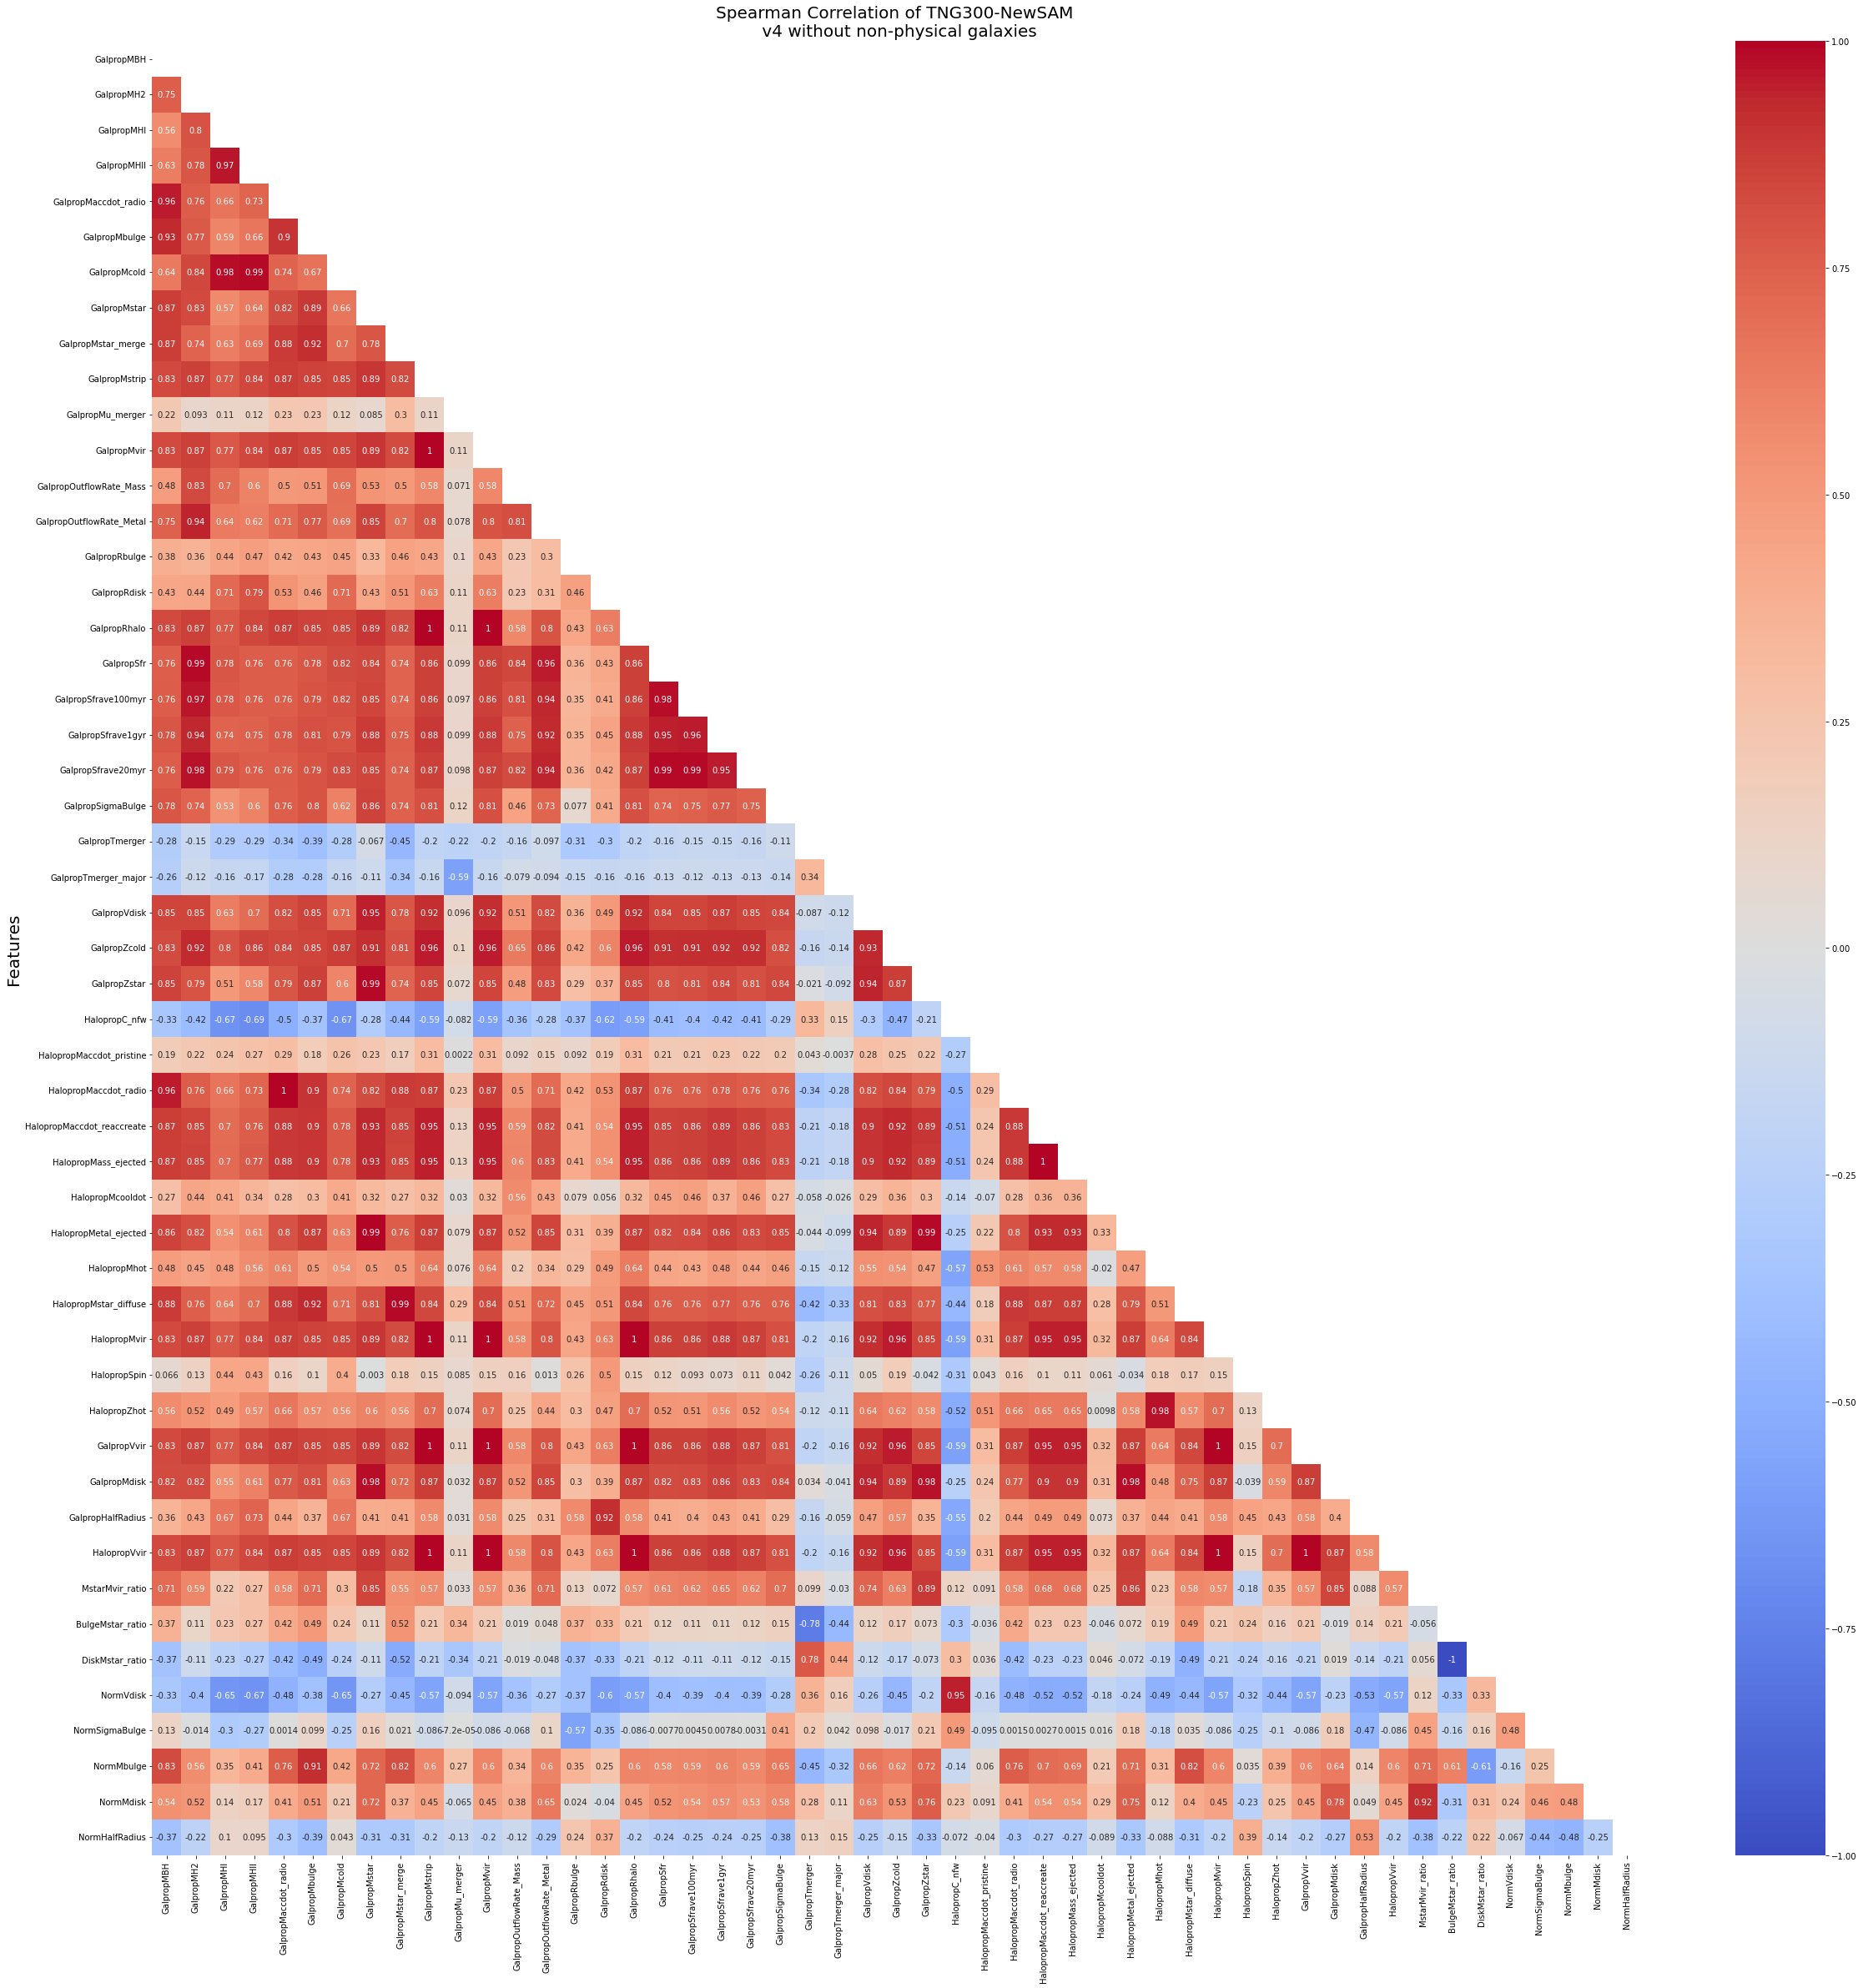

In [76]:
corr_df2 = df_pairplot2.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix2 = np.triu(corr_df2) # take upper correlation matrix
sns.heatmap(corr_df2, cmap="coolwarm",annot=True, mask=matrix2)
plt.title("Spearman Correlation of TNG300-NewSAM \n v4 without non-physical galaxies", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_Spearman_correlation_matrix_v4without_nonphys_gals.jpeg', dpi=500)
plt.show()

### <font color='darkviolet'> Size, Mass and Halo Spin plot



In [77]:
mass_size_corr = round(stats.spearmanr(df_centrals_log['GalpropLogMstar'], 
                                               df_centrals_log['GalpropLogHalfRadius'])[0], 2)
SFR_size_corr = round(stats.spearmanr(df_centrals_log['GalpropLogSfr'], 
                                              df_centrals_log['GalpropLogHalfRadius'] )[0], 2)
SFR_mass_corr = round(stats.spearmanr(df_centrals_log['GalpropLogSfr'], 
                                              df_centrals_log['GalpropLogMstar'] )[0], 2)
mom_size_corr = round(stats.spearmanr(df_centrals_log['HalopropSpin'], 
                                              df_centrals_log['GalpropLogHalfRadius'])[0], 2)
print('mass_size_corr:', mass_size_corr)
print('SFR_size_corr:', SFR_size_corr)
print('SFR_mass_corr:', SFR_mass_corr)
print('mom_size_corr:', mom_size_corr)

mass_size_corr: 0.4
SFR_size_corr: 0.41
SFR_mass_corr: 0.84
mom_size_corr: 0.45


For comparison, the same correlations in the old SAM dataset were:

        mass_size_corr: 0.27
        SFR_size_corr: 0.2
        SFR_mass_corr: 0.78
        mom_size_corr: 0.62

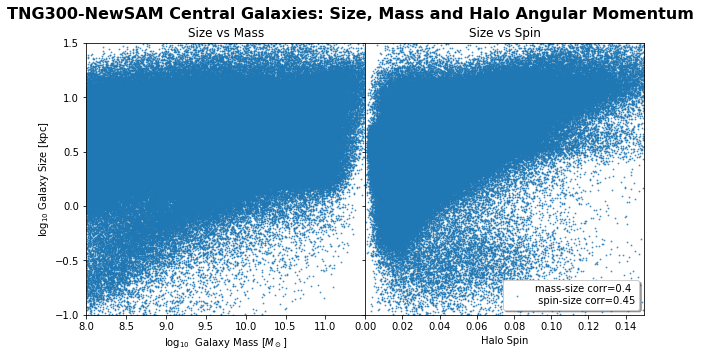

In [79]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG300-NewSAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_centrals_log['GalpropLogMstar'], df_centrals_log['GalpropLogHalfRadius'], 
                    s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-1.0,1.5])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = 'mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df_centrals_log['HalopropSpin'], df_centrals_log['GalpropLogHalfRadius'], 
                     s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_centrals_Mass_Size_AngMom.jpeg", dpi=500)
plt.show()

#### For comparison, the same plot from the old TNG100-SAM

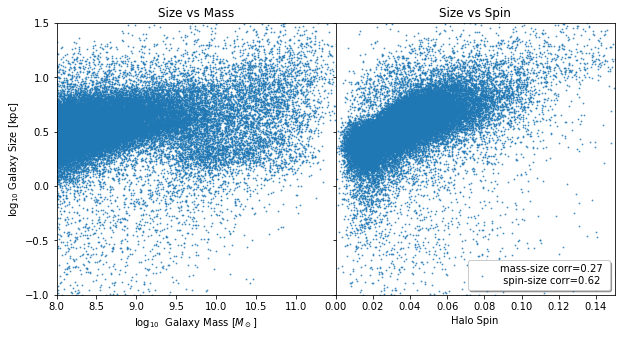

In [22]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_log_mass_filtered['GalpropLogMstar'], df_log_mass_filtered['GalpropLogHalfRadius'], 
                    s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-1.0,1.5])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = 'mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df_log_mass_filtered['HalopropSpin'], df_log_mass_filtered['GalpropLogHalfRadius'], 
                     s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_centrals_Mass_Size_AngMom_v5_log.jpeg", dpi=500)
plt.show()

## <font color='darkviolet'> Normalize the Dataset (similar to v7 Notebook for Old SAM dataset)

#### Check if SigmaBulge or Vdisk are equal Vvir

In [80]:
np.round(df_centrals_log['GalpropVdisk'],2).equals(np.round(df_centrals_log['HalopropVvir'],2))

False

In [81]:
np.round(df_centrals_log['GalpropSigmaBulge'],2).equals(np.round(df_centrals_log['HalopropVvir'],2))

False

In [82]:
print('Vdisk-Rdisk corr:',round(stats.spearmanr(df_centrals_log['GalpropVdisk'], df_centrals_log['GalpropRdisk'])[0], 2))
print('Vdisk-Mvir corr:',round(stats.spearmanr(df_centrals_log['GalpropVdisk'], df_centrals_log['HalopropMvir'])[0], 2))

Vdisk-Rdisk corr: 0.49
Vdisk-Mvir corr: 0.92


#### <font color='indigo'> Drop the not needed columns

In [83]:
df_centrals_log.shape

(813838, 59)

In [84]:
df_centrals_log.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropSpin',
 'HalopropZhot',
 'GalpropVvir',
 'GalpropMdisk',
 'GalpropHalfRadius',
 'HalopropVvir',
 'GalpropLogMstar',
 'GalpropLogHalfRadius',
 'HalopropLogMvir',
 'HalopropLogMhot',
 'GalpropLogMbulge',
 'GalpropL

Note: In the old SAM, HalopropMaccdot_pristine was 100% 0s. In the new SAM, HalopropMaccdot_pristine is only 46% 0s. Therefore, I think I should not remove it as a feature here. 

In [87]:
df_centrals_log=df_centrals_log.drop(columns =['GalpropTsat',
                                               'GalpropLogMstar', 'GalpropLogHalfRadius', 'HalopropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction',
                                               'GalpropRbulge',  'GalpropRdisk', 'GalpropVvir', 'GalpropMvir'])

KeyError: "['GalpropTsat' 'GalpropLogMstar' 'GalpropLogHalfRadius' 'HalopropLogMvir'\n 'HalopropLogMhot' 'GalpropLogMbulge' 'GalpropLogSfr'\n 'GalpropLogSfrave100myr' 'GalpropLogSfrave1gyr' 'GalpropLogSfrave20myr'\n 'Galprop_neutral_H_mass' 'Galprop_baryon_mass' 'Galprop_gas_fraction'\n 'GalpropRbulge' 'GalpropRdisk' 'GalpropVvir'] not found in axis"

In [88]:
df_centrals_log=df_centrals_log.drop(columns =[ 'GalpropMvir'])

In [89]:
df_centrals_log.shape

(813838, 42)

### Normalize the dataset by dividing masses by Mhalo and size by Rhalo


In [12]:
def normalization_func(df):
    '''
    Normalizes the dataset by dividing all masses by halo mass, and galaxy size by halo size

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    
    halomass=df.loc[:,'HalopropMvir']
    halorad= df.loc[:,'GalpropRhalo']
    
    df.loc[:,'GalpropNormHalfRadius']=df.loc[:,'GalpropHalfRadius']/halorad
    df.loc[:,'GalpropNormRhalo']=df.loc[:,'GalpropRhalo']/halorad

    df.loc[:,'GalpropNormMstar']=df.loc[:,'GalpropMstar']/halomass
#     df.loc[:,'GalpropNormMvir']=df.loc[:,'GalpropMvir']/halomass
    df.loc[:,'HalopropNormMhot']=df.loc[:,'HalopropMhot']/halomass
    df.loc[:,'GalpropNormMbulge']=df.loc[:,'GalpropMbulge']/halomass
    df.loc[:,'GalpropNormMdisk']=df.loc[:,'GalpropMdisk']/halomass

    
    df.loc[:,'GalpropNormMBH']=df.loc[:,'GalpropMBH']/halomass
    df.loc[:,'GalpropNormMH2']=df.loc[:,'GalpropMH2']/halomass
    df.loc[:,'GalpropNormMHI']=df.loc[:,'GalpropMHI']/halomass
    df.loc[:,'GalpropNormMHII']=df.loc[:,'GalpropMHII']/halomass
    df.loc[:,'GalpropNormMcold']=df.loc[:,'GalpropMcold']/halomass
    df.loc[:,'GalpropNormMstar_merge']=df.loc[:,'GalpropMstar_merge']/halomass
#     df.loc[:,'GalpropNormMstrip']=df.loc[:,'GalpropMstrip']/halomass
    
    df.loc[:,'HalopropNormMass_ejected']=df.loc[:,'HalopropMass_ejected']/halomass
    df.loc[:,'HalopropNormMstar_diffuse']=df.loc[:,'HalopropMstar_diffuse']/halomass
    df.loc[:,'HalopropNormMvir']=df.loc[:,'HalopropMvir']/halomass
    
    df.loc[:,'GalpropNormSigmaBulge']=df.loc[:,'GalpropSigmaBulge']/df.loc[:,'HalopropVvir']
    df.loc[:,'GalpropNormVdisk']=df.loc[:,'GalpropVdisk']/df.loc[:,'HalopropVvir']
    
    return df

In [91]:
df_centrals_log.shape

(813838, 42)

In [92]:
df_normalized=normalization_func(df_centrals_log)

In [93]:
df_normalized.shape

(813838, 59)

In [94]:
df_normalized.head(2)

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  \
0  70113.099355  5.334980e+06  8.410620e+07  8.798940e+07   
1  40086.601075  5.297840e+06  1.181020e+08  1.186890e+08   

   GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  GalpropMstar  \
0          1.041410e-08   4.956340e+07  2.401300e+08  1.498290e+08   
1          5.833360e-09   4.106860e+07  3.281030e+08  2.677310e+08   

   GalpropMstar_merge  GalpropMstrip  GalpropMu_merger  \
0        1.260270e+06   2.258640e+10          0.139166   
1        1.462520e+06   3.417480e+10          0.123353   

   GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  GalpropRhalo  \
0                 0.273785                  0.016982     74.467804   
1                 0.524337                  0.032891     85.491300   

   GalpropSfr  GalpropSfrave100myr  GalpropSfrave1gyr  GalpropSfrave20myr  \
0    0.004072             0.003734           0.004101            0.002496   
1    0.009404             0.008752           0.011879            0.005768   

   GalpropSigmaBulge  GalpropTmerger  GalpropTmerger_major  GalpropVdisk  \
0             29.519        3.092340              113.7020         56.50   
1             33.430        0.869185               12.6061         62.53   

   GalpropZcold  GalpropZstar  HalopropC_nfw  HalopropMaccdot_pristine  \
0      0.014896      0.011260        30.1965                       0.0   
1      0.020568      0.020358        31.3643                       0.0   

   HalopropMaccdot_radio  HalopropMaccdot_reaccreate  HalopropMass_ejected  \
0           1.041410e-08                    0.312146          6.264690e+09   
1           5.833360e-09                    0.622176          1.248560e+10   

   HalopropMcooldot  HalopropMetal_ejected  HalopropMhot  \
0      3.124880e+08                0.29478   3334.919938   
1      6.242520e+08                0.53540  20187.000700   

   HalopropMstar_diffuse  HalopropMvir  HalopropSpin  HalopropZhot  \
0          315067.009069  2.258640e+10       0.01981    206.850999   
1          814342.987724  3.417480e+10       0.01449    925.469976   

   GalpropMdisk  GalpropHalfRadius  HalopropVvir  MstarMvir_ratio  \
0  1.002656e+08           2.172346     36.256929         0.006634   
1  2.266624e+08           2.727576     41.624020         0.007834   

   BulgeMstar_ratio  DiskMstar_ratio  GalpropNormHalfRadius  GalpropNormRhalo  \
0          0.330800         0.669200               0.029172               1.0   
1          0.153395         0.846605               0.031905               1.0   

   GalpropNormMstar  HalopropNormMhot  GalpropNormMbulge  GalpropNormMdisk  \
0          0.006634      1.476517e-07           0.002194          0.004439   
1          0.007834      5.906984e-07           0.001202          0.006632   

   GalpropNormMBH  GalpropNormMH2  GalpropNormMHI  GalpropNormMHII  \
0        0.000003        0.000236        0.003724         0.003896   
1        0.000001        0.000155        0.003456         0.003473   

   GalpropNormMcold  GalpropNormMstar_merge  HalopropNormMass_ejected  \
0          0.010632                0.000056                  0.277366   
1          0.009601                0.000043                  0.365345   

   HalopropNormMstar_diffuse  HalopropNormMvir  GalpropNormSigmaBulge  \
0                   0.000014               1.0               0.814162   
1                   0.000024               1.0               0.803142   

   GalpropNormVdisk  
0          1.558323  
1          1.502258

In [95]:
df_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropRhalo',
       'GalpropSfr', 'GalpropSfrave100myr', 'GalpropSfrave1gyr',
       'GalpropSfrave20myr', 'GalpropSigmaBulge', 'GalpropTmerger',
       'GalpropTmerger_major', 'GalpropVdisk', 'GalpropZcold', 'GalpropZstar',
       'HalopropC_nfw', 'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropSpin', 'HalopropZhot',
       'GalpropMdisk', 'GalpropHalfRadius', 'HalopropVvir', 'MstarMvir_ratio',
       'BulgeMstar_ratio', 'DiskMstar_ratio', 'GalpropNormHalfRadius',
       'GalpropNormRhalo',

In [96]:
df_normalized_v1 = df_normalized.loc[:, :]

In [97]:
# drop the original columns of normalized features + columns used for normalization + MstarMvir_ratio(bec same as NormMstar now)
df_normalized_v1=df_normalized_v1.drop(columns=['GalpropHalfRadius',  'GalpropMstar','HalopropMhot',
                                                  'GalpropMbulge','GalpropMdisk', 'GalpropMBH','GalpropMH2',
                                                  'GalpropMHI','GalpropMHII','GalpropMcold',
                                                  'GalpropMstar_merge','HalopropMass_ejected',
                                                  'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 
                                                  'GalpropRhalo','GalpropNormRhalo', 'HalopropVvir',
                                                  'GalpropSigmaBulge', 'GalpropVdisk', 'MstarMvir_ratio'])

In [98]:
df_normalized_v1.shape # 3 features less than before normalization bec we're also droping Rhalo, Mvir, Vvir used for normalization

(813838, 38)

# <a id =2> </a> <br> Save the Normalized data set and use it in the next version of the notebook

In [99]:
# df_normalized_v1.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1.csv', index=False)

In [74]:
df_normalized_v1 = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1.csv') # df here read from the csv in previous line

In [101]:
df_normalized_v1.columns.to_list()

['GalpropMaccdot_radio',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropSpin',
 'HalopropZhot',
 'BulgeMstar_ratio',
 'DiskMstar_ratio',
 'GalpropNormHalfRadius',
 'GalpropNormMstar',
 'HalopropNormMhot',
 'GalpropNormMbulge',
 'GalpropNormMdisk',
 'GalpropNormMBH',
 'GalpropNormMH2',
 'GalpropNormMHI',
 'GalpropNormMHII',
 'GalpropNormMcold',
 'GalpropNormMstar_merge',
 'HalopropNormMass_ejected',
 'HalopropNormMstar_diffuse',
 'GalpropNormSigmaBulge',
 'GalpropNormVdisk']

In [102]:
# Remove non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2
df_normalized_v1_wo_nonphysgals = df_normalized_v1[df_normalized_v1.GalpropNormMstar < 0.2]

In [103]:
df_normalized_v1_wo_nonphysgals.shape

(813457, 38)

In [104]:
# df_normalized_v1_wo_nonphysgals.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_nonphysgals.csv', index=False)

In [105]:
mass_size_corr_norm = round(stats.spearmanr(df_normalized_v1['GalpropNormMstar'], 
                                               df_normalized_v1['GalpropNormHalfRadius'])[0], 2)
SFR_size_corr_norm = round(stats.spearmanr(df_normalized_v1['GalpropSfr'], 
                                              df_normalized_v1['GalpropNormHalfRadius'] )[0], 2)
SFR_mass_corr_norm = round(stats.spearmanr(df_normalized_v1['GalpropSfr'], 
                                              df_normalized_v1['GalpropNormMstar'] )[0], 2)
mom_size_corr_norm = round(stats.spearmanr(df_normalized_v1['HalopropSpin'], 
                                              df_normalized_v1['GalpropNormHalfRadius'])[0], 2)
print('mass_size_corr_norm:', mass_size_corr_norm)
print('SFR_size_corr_norm:', SFR_size_corr_norm)
print('SFR_mass_corr_norm:', SFR_mass_corr_norm)
print('mom_size_corr_norm:', mom_size_corr_norm)

mass_size_corr_norm: -0.38
SFR_size_corr_norm: -0.24
SFR_mass_corr_norm: 0.61
mom_size_corr_norm: 0.39


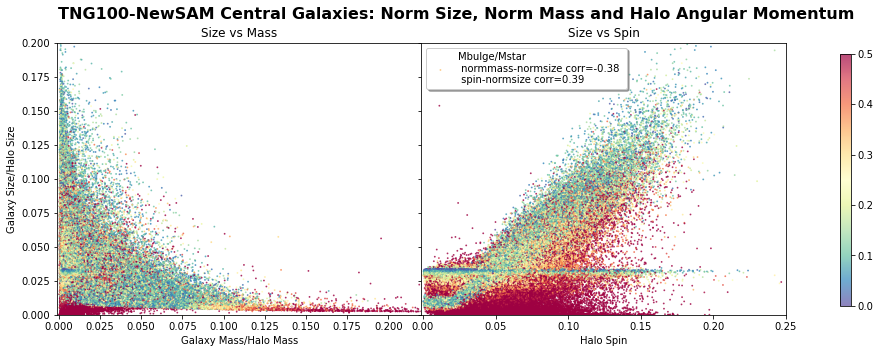

In [124]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG100-NewSAM Central Galaxies: Norm Size, Norm Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = ('Mbulge/Mstar \n normmass-normsize corr=-0.38 \n spin-normsize corr=0.39')
im1 = ax1.scatter(df_normalized_v1.loc[:, 'GalpropNormMstar'], df_normalized_v1.loc[:, 'GalpropNormHalfRadius'], 
                  c = (df_normalized_v1.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', vmin=0.0, vmax=0.5)

ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0,0.2])
ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Galaxy Size/Halo Size')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized_v1.loc[:, 'HalopropSpin'], df_normalized_v1.loc[:, 'GalpropNormHalfRadius'], 
                    c = (df_normalized_v1.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                    label=label, cmap='Spectral_r', vmin=0.0, vmax=0.5)

     
ax2.set_xlim([-0.001,0.25])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_NormalizedMass_NormalizedSize_Spin.jpeg", dpi=500)
plt.show()

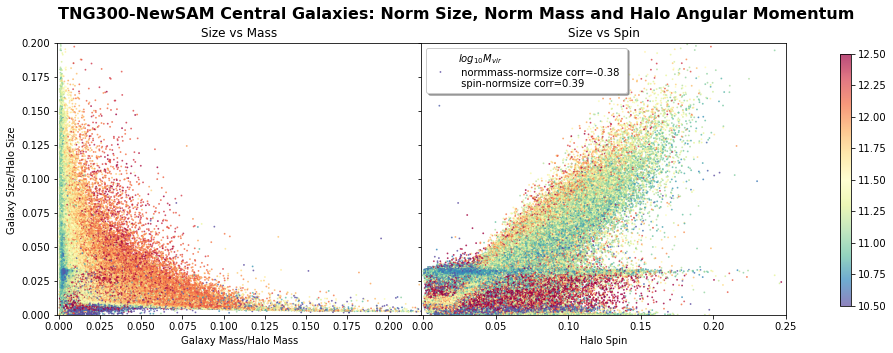

In [123]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG300-NewSAM Central Galaxies: Norm Size, Norm Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = (r'$log_{10}M_{vir}$' +' \n normmass-normsize corr=-0.38 \n spin-normsize corr=0.39')
im1 = ax1.scatter(df_normalized.loc[:, 'GalpropNormMstar'], df_normalized.loc[:, 'GalpropNormHalfRadius'], 
                  c = (np.log10(df_normalized.loc[:, 'HalopropMvir'])),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', vmin=10.5, vmax=12.5)

ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0, 0.2])
ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Galaxy Size/Halo Size ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized.loc[:, 'HalopropSpin'], df_normalized.loc[:, 'GalpropNormHalfRadius'], 
                    c = (np.log10(df_normalized.loc[:, 'HalopropMvir'])),  s=3, marker='.', alpha=0.7, 
                    label=label, cmap='Spectral_r', vmin=10.5, vmax=12.5)

     
ax2.set_xlim([-0.001,0.25])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_NormalizedMass_NormalizedSize_Spin_colorbarMvir.jpeg", dpi=500)
plt.show()

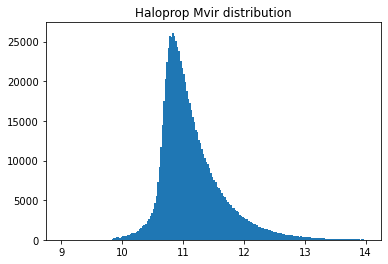

In [170]:
plt.hist(np.log10(df_normalized.loc[:, 'HalopropMvir']), range=(9.0, 14.0), bins=200)
plt.title('Haloprop Mvir distribution')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300_HalopropMvir_distribution', dpi=500)
plt.show()

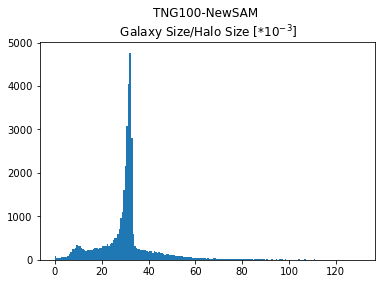

In [55]:
# TNG100-NewSAM half rad distribution
plt.hist(df_normalized_v36.loc[:, 'GalpropNormHalfRadius']) #, range=(0,130), bins=200)
plt.title('TNG100-NewSAM \n Galaxy Size/Halo Size]')
# plt.savefig('v36_TNG100-NewSAM_NormHalfRad_histogram2.jpeg', dpi=500)
plt.show()

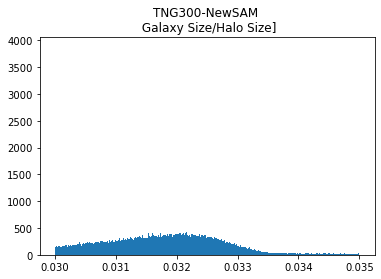

In [78]:
plt.hist(df_normalized_v1.loc[:, 'GalpropNormHalfRadius'], range=(0.03,0.035), bins=2000)
plt.title('TNG300-NewSAM \n Galaxy Size/Halo Size]')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_NormHalfRad_histogram2.jpeg', dpi=500)
plt.show()

In [85]:
df_centrals_log_v1_wo_nonphysgals.shape

(813457, 59)

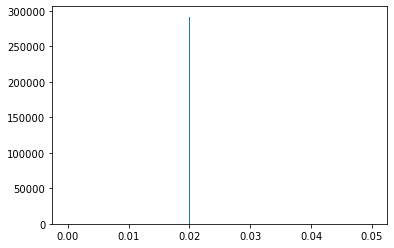

In [84]:
plt.hist(df_centrals_log_v1_wo_nonphysgals.loc[:, 'GalpropRdisk']/df_centrals_log_v1_wo_nonphysgals.loc[:, 'GalpropRhalo'], 
         range=(0.0, 0.05), bins=2000)
plt.show()

## <font color='darkviolet'> Correlations Matrix of Normalized the Dataset 

In [130]:
df_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropRhalo',
       'GalpropSfr', 'GalpropSfrave100myr', 'GalpropSfrave1gyr',
       'GalpropSfrave20myr', 'GalpropSigmaBulge', 'GalpropTmerger',
       'GalpropTmerger_major', 'GalpropVdisk', 'GalpropZcold', 'GalpropZstar',
       'HalopropC_nfw', 'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropSpin', 'HalopropZhot',
       'GalpropMdisk', 'GalpropHalfRadius', 'HalopropVvir', 'MstarMvir_ratio',
       'BulgeMstar_ratio', 'DiskMstar_ratio', 'GalpropNormHalfRadius',
       'GalpropNormRhalo',

In [131]:
df_pairplot_norm=df_normalized.loc[:,['GalpropMaccdot_radio', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropZcold',
       'GalpropZstar', 'HalopropC_nfw', 'HalopropMaccdot_pristine',
       'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropSpin',
       'HalopropZhot', 'GalpropMdisk', 'MstarMvir_ratio', 'BulgeMstar_ratio',
       'DiskMstar_ratio', 'GalpropNormMstar',
       'HalopropNormMhot', 'GalpropNormMbulge', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'GalpropNormSigmaBulge', 'GalpropNormVdisk', 'GalpropNormHalfRadius']]

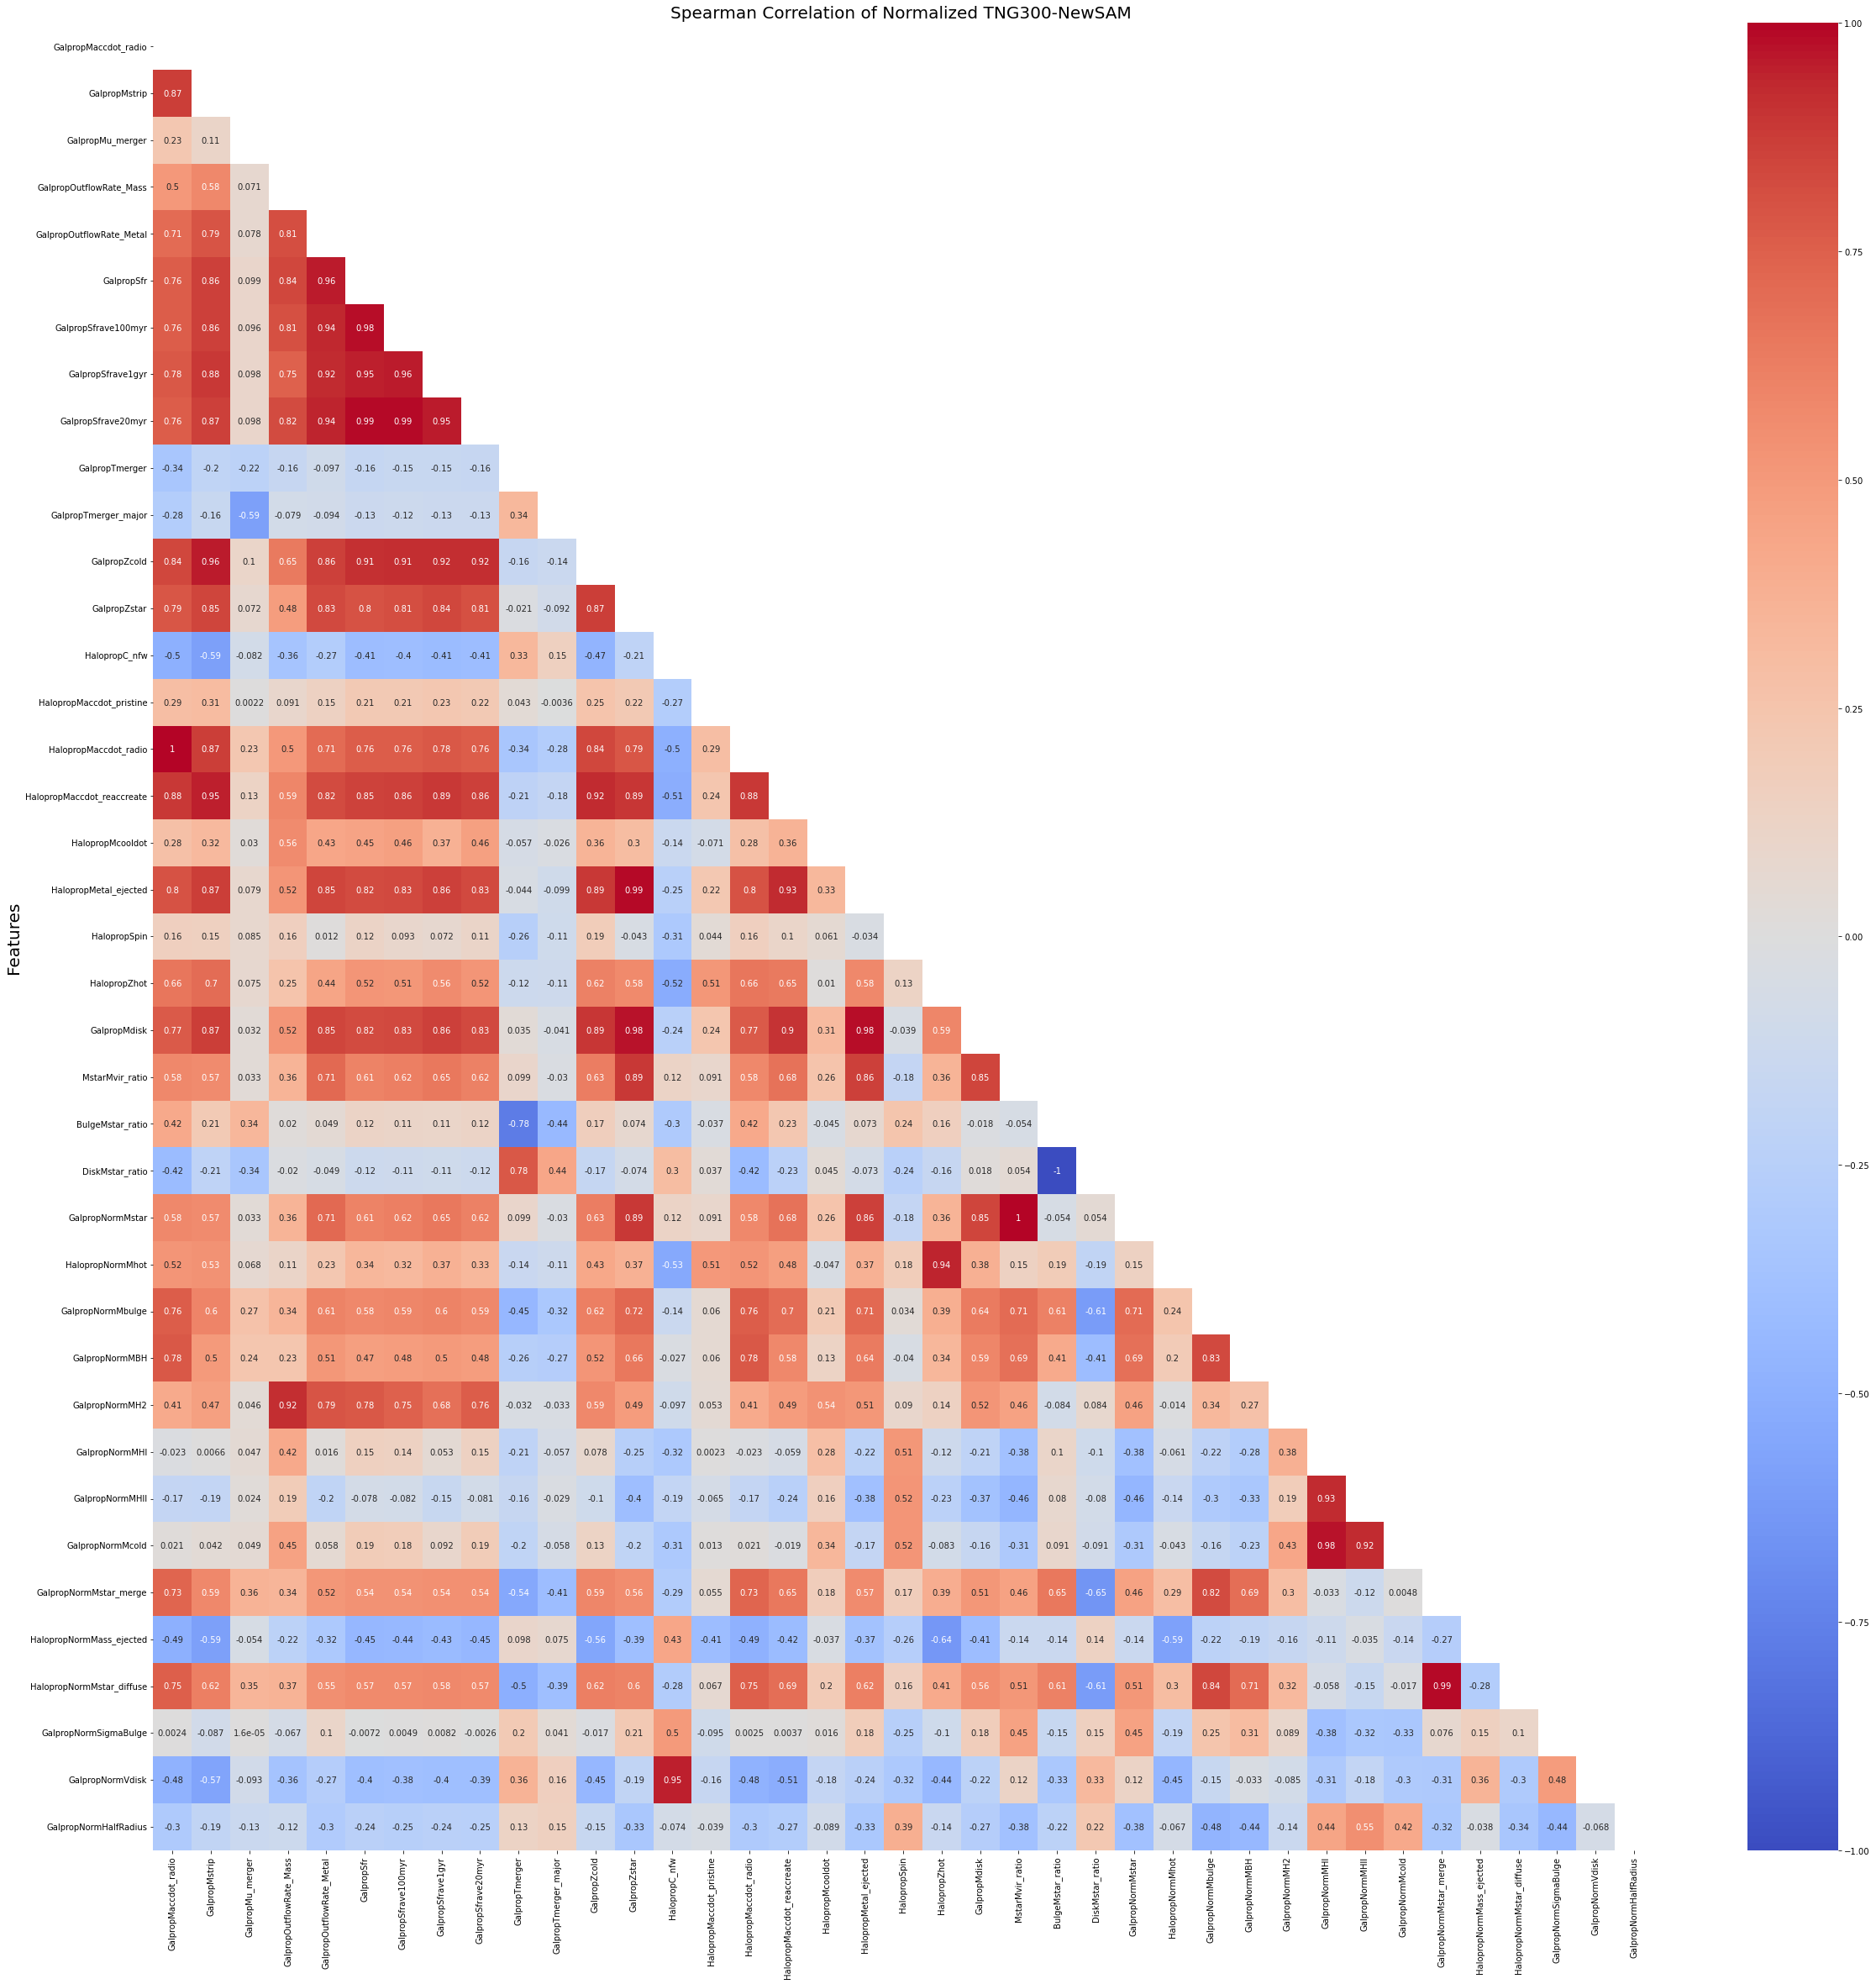

In [172]:
corr_df_norm = df_pairplot_norm.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix_norm = np.triu(corr_df_norm) # take upper correlation matrix
sns.heatmap(corr_df_norm, cmap="coolwarm",annot=True, mask=matrix_norm)
plt.title("Spearman Correlation of Normalized TNG300-NewSAM ", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-newSAM_morefeatures_Spearman_Normalized_correlation_matrix.jpeg', dpi=500)
plt.show()

 #### <font color='red'> Note: 1) NormVdisk-C-nfw is 0.95 in the new SAM. It used to be -0.053 in the old SAM. 2) NormHalfRad-Spin is 0.4 now (old SAM 0.6) - which is comparable to Mcold now. 3) NormHalfRad-NormMHII is 0.56 (old SAM 0.6) 

## <font color='darkviolet'> Correlations of Mbulge-Mstar in Raw vs Normalized the Dataset with and without non-physical galaxies

#### Raw Dataset

In [135]:
mstar_mbulge_corr_spearman = round(stats.spearmanr(df_centrals_log['GalpropMstar'], 
                                               df_centrals_log['GalpropMbulge'])[0], 2)
mstar_mbulge_corr_spearman_wo_nophysgals = round(stats.spearmanr(df_centrals_log_v1_wo_nonphysgals['GalpropMstar'], 
                                              df_centrals_log_v1_wo_nonphysgals['GalpropMbulge'] )[0], 2)

print('Raw Mstar-Mbulge Spearman Correlation:', mstar_mbulge_corr_spearman)
print('Raw Mstar-Mbulge Spearman Correlation without Non-Physical Galaxies:', mstar_mbulge_corr_spearman_wo_nophysgals)


Raw Mstar-Mbulge Spearman Correlation: 0.89
Raw Mstar-Mbulge Spearman Correlation without Non-Physical Galaxies: 0.89


In [136]:
mstar_mbulge_corr_pearson = round(stats.pearsonr(df_centrals_log['GalpropMstar'], 
                                               df_centrals_log['GalpropMbulge'])[0], 2)
mstar_mbulge_corr_spearman_wo_nophysgals = round(stats.pearsonr(df_centrals_log_v1_wo_nonphysgals['GalpropMstar'], 
                                              df_centrals_log_v1_wo_nonphysgals['GalpropMbulge'] )[0], 2)

print('Raw Mstar-Mbulge Pearson Correlation:', mstar_mbulge_corr_spearman)
print('Raw Mstar-Mbulge Pearson Correlation without Non-Physical Galaxies:', mstar_mbulge_corr_spearman_wo_nophysgals)


Raw Mstar-Mbulge Pearson Correlation: 0.89
Raw Mstar-Mbulge Pearson Correlation without Non-Physical Galaxies: 0.92


#### <font color='darkred'> For comparison, in the old SAM (TNG100), Mstar-Mbulge correlations in the Raw dataset were:
  
     1) Raw MStar-Mbulge Spearman: 0.91
     2) Raw Mstar-Mbulge Spearman without Non-Phys Gals: 0.91
     3) Raw Mstar-Mbulge Pearson: 0.91
     4) Raw Mstar-Mbulge Pearson without Non-Phys Gals: 0.91


#### Normalized Dataset

In [138]:
norm_mstar_mbulge_corr_spearman = round(stats.spearmanr(df_normalized_v1['GalpropNormMstar'], 
                                               df_normalized_v1['GalpropNormMbulge'])[0], 2)
norm_mstar_mbulge_corr_spearman_wo_nophysgals = round(stats.spearmanr(df_normalized_v1_wo_nonphysgals['GalpropNormMstar'], 
                                              df_normalized_v1_wo_nonphysgals['GalpropNormMbulge'] )[0], 2)

print('Normalized Mstar-Mbulge Spearman Correlation:', norm_mstar_mbulge_corr_spearman)
print('Normalized Mstar-Mbulge Spearman Correlation without Non-Physical Galaxies:', norm_mstar_mbulge_corr_spearman_wo_nophysgals)


Normalized Mstar-Mbulge Spearman Correlation: 0.71
Normalized Mstar-Mbulge Spearman Correlation without Non-Physical Galaxies: 0.71


In [139]:
norm_mstar_mbulge_corr_pearson = round(stats.pearsonr(df_normalized_v1['GalpropNormMstar'], 
                                               df_normalized_v1['GalpropNormMbulge'])[0], 2)
norm_mstar_mbulge_corr_pearson_wo_nophysgals = round(stats.pearsonr(df_normalized_v1_wo_nonphysgals['GalpropNormMstar'], 
                                              df_normalized_v1_wo_nonphysgals['GalpropNormMbulge'] )[0], 2)

print('Normalized Mstar-Mbulge Pearson Correlation:', norm_mstar_mbulge_corr_pearson)
print('Normalized Mstar-Mbulge Pearson Correlation without Non-Physical Galaxies:', norm_mstar_mbulge_corr_pearson_wo_nophysgals)


Normalized Mstar-Mbulge Pearson Correlation: 0.89
Normalized Mstar-Mbulge Pearson Correlation without Non-Physical Galaxies: 0.71


#### <font color='darkred'> For comparison, in the old SAM (TNG100), Mstar-Mbulge correlations in the Normalized dataset were:
  
     1) Normalized Mstar-Mbulge Spearman: 0.76
     2) Normalized Mstar-Mbulge Spearman without Non-Phys Gals: 0.76
     3) Normalized Mstar-Mbulge Pearson: 0.99
     4) Normalized Mstar-Mbulge Pearson without Non-Phys Gals: 0.71


# <font color='red'> Conclusion: Use the Normalized dataset without non-physical galaxies in the following steps of analysis: ML modelling and search for physical model.

## <font color='darkviolet'> Fdisk<0.02 problem

In [140]:
# From the True Physical formula, fdisk is defined as below:
# mdisk = (mstar_disk + mass_cold_gas)
# fdisk = mdisk/m_halo
# In our normalized dataset, NormMstar=Mstar/Mhalo and NormMcold=Mcold/Mhalo, so fdisk = NormMstar + NormMcold
df_all = df_normalized_v1.loc[:, :]
df_all.loc[:, 'fdisk'] = df_all.loc[:, 'GalpropNormMstar'] + df_all.loc[:, 'GalpropNormMcold']

In [159]:
df_normalized.shape #include non-phys gals

(813838, 59)

In [158]:
df_all.shape

(813838, 39)

In [144]:
df_not_normalized = df_centrals_log_v1 = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphysgals.csv') 
df_all_raw = df_not_normalized.loc[:, :]
df_all_raw.loc[:, 'fdisk'] = (df_all_raw.loc[:, 'GalpropMstar'] + df_all_raw.loc[:, 'GalpropMcold'])/df_all_raw.loc[:, 'HalopropMvir']

In [147]:
df_small_fdisk_raw = df_all_raw[df_all_raw.fdisk<0.02]
df_small_fdisk_raw.shape

(403529, 60)

In [148]:
df_small_fdisk = df_all[df_all.fdisk<0.02]
df_small_fdisk.shape

(403529, 39)

#### 403,529 out of  a total of  813,457 are fdisk<0.02. That is 49.6 % (~50%).

In [161]:
(403529*100)/813457

49.60667865664688

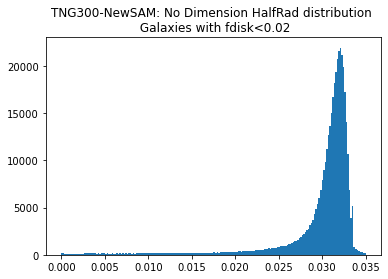

In [173]:
plt.hist(df_small_fdisk.GalpropNormHalfRadius, bins=200, range=(0, 0.035))
plt.title('TNG300-NewSAM: No Dimension HalfRad distribution \n Galaxies with fdisk<0.02')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdisksmall_gals_NormHalfRad_distribution.jpeg', dpi=500)
plt.show()

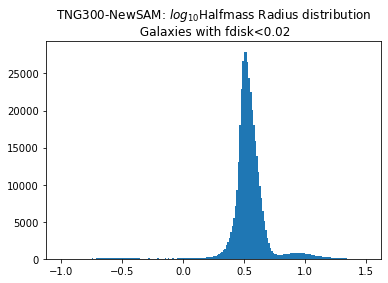

In [174]:
plt.hist(np.log10(df_small_fdisk_raw.GalpropHalfRadius), bins=200, range=(-1.0, 1.5))
plt.title(r'TNG300-NewSAM: $log_{10}$Halfmass Radius distribution' + '\n Galaxies with fdisk<0.02')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdisksmall_gals_HalfRad_distribution.jpeg', dpi=500)
plt.show()

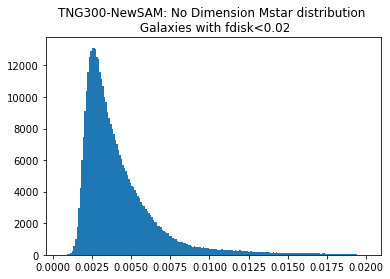

In [175]:
plt.hist(df_small_fdisk.GalpropNormMstar, bins=200) #, range=(0, 40))
plt.title('TNG300-NewSAM: No Dimension Mstar distribution \n Galaxies with fdisk<0.02')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdisksmall_gals_NormMstar_distribution.jpeg', dpi=500)
plt.show()

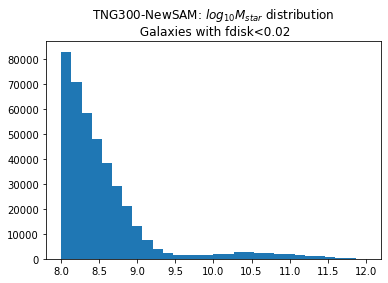

In [176]:
plt.hist(np.log10(df_small_fdisk_raw.GalpropMstar), bins=30, range=(8.0, 12.0))
plt.title(r'TNG300-NewSAM: $log_{10}M_{star}$ distribution' + '\n Galaxies with fdisk<0.02')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdisksmall_gals_log10Mstar_distribution.jpeg', dpi=500)
plt.show()

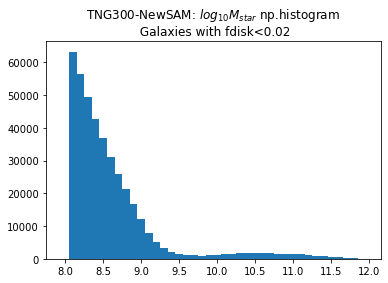

In [177]:
H, bins = np.histogram(np.log10(df_small_fdisk_raw.GalpropMstar), range=(7.9,12), bins=list(np.arange(7.9,12,0.1)))
plt.bar(bins[1:],H, align='center', width = 0.1)
plt.title(r'TNG300-NewSAM: $log_{10}M_{star}$ np.histogram' + '\n Galaxies with fdisk<0.02')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdisksmall_gals_log10Mstar_nphistogram.jpeg', dpi=500)
plt.show()


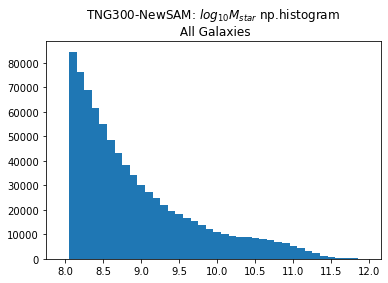

In [178]:
H_all, bins_all = np.histogram(np.log10(df_all_raw.GalpropMstar), range=(7.9,12), bins=list(np.arange(7.9,12,0.1)))
plt.bar(bins_all[1:],H_all, align='center', width = 0.1)
plt.title(r'TNG300-NewSAM: $log_{10}M_{star}$ np.histogram' + '\n All Galaxies')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_all_gals_log10Mstar_nphistogram.jpeg', dpi=500)
plt.show()


/var/folders/ln/75hwm53n5ml0l3lfft4tb7100000gn/T/ipykernel_2377/2755849863.py:1: RuntimeWarning: invalid value encountered in true_divide
  H_frac, bins_frac = H/H_all, bins_all


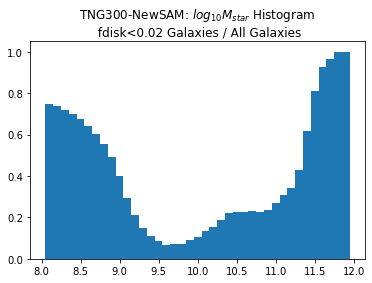

In [179]:
H_frac, bins_frac = H/H_all, bins_all
plt.bar(bins_frac[1:],H_frac, align='center', width = 0.1)
plt.title(r'TNG300-NewSAM: $log_{10}M_{star}$ Histogram' + '\n fdisk<0.02 Galaxies / All Galaxies')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdiskratio_gals_log10Mstar_nphistogram.jpeg', dpi=500)
plt.show()


In [153]:
small_fdisk_spin_normsize = round(stats.spearmanr(df_small_fdisk.loc[:, 'HalopropSpin'], 
                                              df_small_fdisk.loc[:, 'GalpropNormHalfRadius'] )[0], 2)
small_fdisk_spin_normmass = round(stats.spearmanr(df_small_fdisk.loc[:, 'HalopropSpin'], 
                                              df_small_fdisk.loc[:, 'GalpropNormMstar'] )[0], 2)


print('Spin-NormSize correlation in New SAM fdisk<0.02 gals:', small_fdisk_spin_normsize)
print('Spin-NormMstar correlation in New SAM fdisk<0.02 gals:', small_fdisk_spin_normmass)

Spin-NormSize correlation in New SAM fdisk<0.02 gals: -0.07
Spin-NormMstar correlation in New SAM fdisk<0.02 gals: -0.09


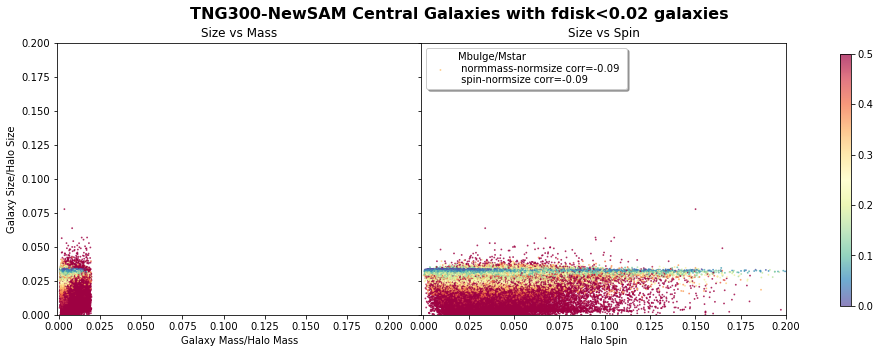

In [180]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG300-NewSAM Central Galaxies with fdisk<0.02 galaxies ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = ('Mbulge/Mstar \n normmass-normsize corr=-0.09 \n spin-normsize corr=-0.09')
im1 = ax1.scatter(df_small_fdisk.loc[:, 'GalpropNormMstar'], df_small_fdisk.loc[:, 'GalpropNormHalfRadius'], 
                  c = (df_small_fdisk.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', vmin=0.0, vmax=0.5)


ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0,0.2])
ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Galaxy Size/Halo Size')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_small_fdisk.loc[:, 'HalopropSpin'], df_small_fdisk.loc[:, 'GalpropNormHalfRadius'], 
                    c = (df_small_fdisk.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                    label=label, cmap='Spectral_r', vmin=0.0, vmax=0.5)

     
ax2.set_xlim([-0.001,0.20])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdisksmall_gals_NormalizedMass_NormalizedSize_Spin.jpeg", dpi=500)
plt.show()

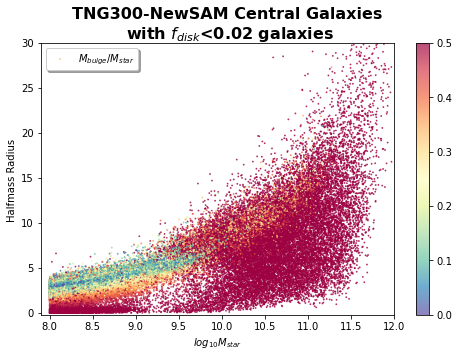

In [181]:
fig,ax1=plt.subplots(nrows=1,ncols=1, figsize=(7,5))
fig.suptitle('TNG300-NewSAM Central Galaxies \n' + r'with $f_{disk}$<0.02 galaxies ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(np.log10(df_small_fdisk_raw.loc[:, 'GalpropMstar']), df_small_fdisk_raw.loc[:, 'GalpropHalfRadius'], 
                  c = (df_small_fdisk_raw.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', label=r'$M_{bulge}/M_{star}$', vmin=0.0, vmax=0.5)

ax1.set_xlim([7.9, 12.0])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([-0.2,30])
# ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel(r'$log_{10} M_{star}$')
ax1.set_ylabel('Halfmass Radius ')
ax1.legend(loc='upper left', shadow=True)
fig.colorbar(im1, ax=ax1)

fig.subplots_adjust(right=1.0)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im1, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/v1_TNG300-NewSAM_fdisksmall_gals_Mass_Size.jpeg", dpi=500)
plt.show()

# <font color='red'> Conclusion: Remove all galaxies with $log_{10}M_{star}$ <9.0 in order to reduce the presence of $f_{disk}$ <0.02 galaxies.

## <font color='darkviolet'>  <a id =3> </a> <br> Re-define dataset with the new mass cut: All galaxies with $log_{10}M_{star}$ >9.0

### Raw Dataset

In [10]:
df_raw = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1.csv') 

In [11]:
df_raw.shape

(813838, 59)

In [14]:
df_raw.head(2)

GalpropMBH    GalpropMH2    GalpropMHI   GalpropMHII  \
0  70113.099355  5.334980e+06  8.410620e+07  8.798940e+07   
1  40086.601075  5.297840e+06  1.181020e+08  1.186890e+08   

   GalpropMaccdot_radio  GalpropMbulge  GalpropMcold  GalpropMstar  \
0          1.041410e-08   4.956340e+07  2.401300e+08  1.498290e+08   
1          5.833360e-09   4.106860e+07  3.281030e+08  2.677310e+08   

   GalpropMstar_merge  GalpropMstrip  GalpropMu_merger   GalpropMvir  \
0        1.260270e+06   2.258640e+10          0.139166  2.258640e+10   
1        1.462520e+06   3.417480e+10          0.123353  3.417480e+10   

   GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  GalpropRbulge  \
0                 0.273785                  0.016982        1.28589   
1                 0.524337                  0.032891        1.60926   

   GalpropRdisk  GalpropRhalo  GalpropSfr  GalpropSfrave100myr  \
0       1.48936     74.467804    0.004072             0.003734   
1       1.70983     85.491300    0.009404             0.008752   

   GalpropSfrave1gyr  GalpropSfrave20myr  GalpropSigmaBulge  GalpropTmerger  \
0           0.004101            0.002496             29.519        3.092340   
1           0.011879            0.005768             33.430        0.869185   

   GalpropTmerger_major  GalpropTsat  GalpropVdisk  GalpropZcold  \
0              113.7020        -99.0         56.50      0.014896   
1               12.6061        -99.0         62.53      0.020568   

   GalpropZstar  HalopropC_nfw  HalopropMaccdot_pristine  \
0      0.011260        30.1965                       0.0   
1      0.020358        31.3643                       0.0   

   HalopropMaccdot_radio  HalopropMaccdot_reaccreate  HalopropMass_ejected  \
0           1.041410e-08                    0.312146          6.264690e+09   
1           5.833360e-09                    0.622176          1.248560e+10   

   HalopropMcooldot  HalopropMetal_ejected  HalopropMhot  \
0      3.124880e+08                0.29478   3334.919938   
1      6.242520e+08                0.53540  20187.000700   

   HalopropMstar_diffuse  HalopropMvir  HalopropSpin  HalopropZhot  \
0          315067.009069  2.258640e+10       0.01981    206.850999   
1          814342.987724  3.417480e+10       0.01449    925.469976   

   GalpropVvir  GalpropMdisk  GalpropHalfRadius  HalopropVvir  \
0    36.113822  1.002656e+08           2.172346     36.256929   
1    41.459710  2.266624e+08           2.727576     41.624020   

   GalpropLogMstar  GalpropLogHalfRadius  HalopropLogMvir  HalopropLogMhot  \
0         8.175596              0.336929        10.353847         3.523085   
1         8.427699              0.435777        10.533706         4.305072   

   GalpropLogMbulge  GalpropLogSfr  GalpropLogSfrave100myr  \
0          7.695161      -2.390215               -2.427870   
1          7.613510      -2.026706               -2.057871   

   GalpropLogSfrave1gyr  GalpropLogSfrave20myr  Galprop_neutral_H_mass  \
0             -2.387158              -2.602757            8.944118e+07   
1             -1.925213              -2.238952            1.233998e+08   

   Galprop_baryon_mass  Galprop_gas_fraction  MstarMvir_ratio  \
0         2.392702e+08              0.373808         0.006634   
1         3.911309e+08              0.315495         0.007834   

   BulgeMstar_ratio  DiskMstar_ratio  
0          0.330800         0.669200  
1          0.153395         0.846605

In [15]:
# Remove all galaxies with stellar mass log10Mstar<9 and re-define centrals as such:
df_raw_wo_mstar9 = df_raw.loc[df_raw['GalpropMstar']>=1e9, :]

# There are 540,072 (~66%) galaxies with log10Mstar=[8.0, 9.0).  
# That is, 273,766 galaxies (~34%) have a log10Mstar>=9.

In [16]:
df_raw_wo_mstar9.shape

(273766, 59)

In [17]:
# df_raw_wo_mstar9.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_mstar9.csv', index=False)

In [18]:
df_raw_wo_nonphysgals = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphysgals.csv') 

In [19]:
df_raw_wo_nonphysgals.shape

(813457, 59)

In [20]:
# Remove all galaxies with stellar mass log10Mstar<9 and re-define centrals as such:
df_raw_wo_mstar9_wo_nonphysgals = df_raw_wo_nonphysgals.loc[df_raw_wo_nonphysgals['GalpropMstar']>=1e9, :]

In [21]:
df_raw_wo_mstar9_wo_nonphysgals.shape

# There are 381 non-physical galaxies with log10Mstar>=9.0

(273385, 59)

In [22]:
# df_raw_wo_mstar9_wo_nonphysgals.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphysgals_wo_mstar9.csv', index=False)

In [27]:
df_raw_wo_mstar9_wo_nonphysgals.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropSpin',
 'HalopropZhot',
 'GalpropVvir',
 'GalpropMdisk',
 'GalpropHalfRadius',
 'HalopropVvir',
 'GalpropLogMstar',
 'GalpropLogHalfRadius',
 'HalopropLogMvir',
 'HalopropLogMhot',
 'GalpropLogMbulge',
 'GalpropL

###  <a id =4> </a> <br> Normalize the new Dataset without $log_{10}M_{star}$ < 9.0

In [23]:
# Normalized df with stellar mass cut log10Mstar>8.0
df_normalized_all = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1.csv')

In [24]:
df_normalized_all.shape

(813838, 38)

In [26]:
df_normalized_all.columns.to_list()

['GalpropMaccdot_radio',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropSpin',
 'HalopropZhot',
 'BulgeMstar_ratio',
 'DiskMstar_ratio',
 'GalpropNormHalfRadius',
 'GalpropNormMstar',
 'HalopropNormMhot',
 'GalpropNormMbulge',
 'GalpropNormMdisk',
 'GalpropNormMBH',
 'GalpropNormMH2',
 'GalpropNormMHI',
 'GalpropNormMHII',
 'GalpropNormMcold',
 'GalpropNormMstar_merge',
 'HalopropNormMass_ejected',
 'HalopropNormMstar_diffuse',
 'GalpropNormSigmaBulge',
 'GalpropNormVdisk']

In [28]:
# Remove all galaxies with stellar mass log10Mstar<9 and re-define centrals as such:

df_normalized_wo_mstar9 = normalization_func(df_raw_wo_mstar9)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [29]:
df_normalized_wo_mstar9.shape

(273766, 76)

In [30]:
df_normalized_wo_mstar9.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropSpin',
 'HalopropZhot',
 'GalpropVvir',
 'GalpropMdisk',
 'GalpropHalfRadius',
 'HalopropVvir',
 'GalpropLogMstar',
 'GalpropLogHalfRadius',
 'HalopropLogMvir',
 'HalopropLogMhot',
 'GalpropLogMbulge',
 'GalpropL

In [31]:
# drop the original columns of normalized features + columns used for normalization + MstarMvir_ratio(bec same as NormMstar now)
df_normalized_wo_mstar9=df_normalized_wo_mstar9.drop(columns=['GalpropHalfRadius',  'GalpropMstar','HalopropMhot',
                                                  'GalpropMbulge','GalpropMdisk', 'GalpropMBH','GalpropMH2',
                                                  'GalpropMHI','GalpropMHII','GalpropMcold',
                                                  'GalpropMstar_merge','HalopropMass_ejected',
                                                  'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 
                                                  'HalopropVvir',
                                                  'GalpropSigmaBulge', 'GalpropVdisk', 'MstarMvir_ratio',
 'GalpropLogMstar', # drop all the Log features
 'GalpropLogHalfRadius', 'HalopropLogMvir','HalopropLogMhot','GalpropLogMbulge','GalpropLogSfr',
 'GalpropLogSfrave100myr','GalpropLogSfrave1gyr','GalpropLogSfrave20myr',
 'GalpropVvir', # drop GalpropVvir bec I'm using HalopropVvir
 'GalpropTsat',    
 'GalpropRbulge', 'GalpropRdisk','GalpropRhalo' , 'GalpropNormRhalo' ])

In [35]:
df_normalized_wo_mstar9=df_normalized_wo_mstar9.drop(columns=['GalpropMvir',  'Galprop_neutral_H_mass',
 'Galprop_baryon_mass', 'Galprop_gas_fraction'])

In [36]:
df_normalized_wo_mstar9.shape

(273766, 38)

In [37]:
# df_normalized_wo_mstar9.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9.csv', index=False)



In [38]:
# Remove all galaxies with stellar mass log10Mstar<9 and re-define centrals as such:
df_normalized_wo_mstar9_wo_nonphysgals = normalization_func(df_raw_wo_mstar9_wo_nonphysgals)

In [39]:
df_normalized_wo_mstar9_wo_nonphysgals.shape

(273385, 76)

In [40]:
# drop the original columns of normalized features + columns used for normalization + MstarMvir_ratio(bec same as NormMstar now)
df_normalized_wo_mstar9_wo_nonphysgals=df_normalized_wo_mstar9_wo_nonphysgals.drop(columns=['GalpropHalfRadius',  'GalpropMstar','HalopropMhot',
                                                  'GalpropMbulge','GalpropMdisk', 'GalpropMBH','GalpropMH2',
                                                  'GalpropMHI','GalpropMHII','GalpropMcold',
                                                  'GalpropMstar_merge','HalopropMass_ejected',
                                                  'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 
                                                  'HalopropVvir',
                                                  'GalpropSigmaBulge', 'GalpropVdisk', 'MstarMvir_ratio',
 'GalpropLogMstar', # drop all the Log features
 'GalpropLogHalfRadius', 'HalopropLogMvir','HalopropLogMhot','GalpropLogMbulge','GalpropLogSfr',
 'GalpropLogSfrave100myr','GalpropLogSfrave1gyr','GalpropLogSfrave20myr',
 'GalpropVvir', # drop GalpropVvir bec I'm using HalopropVvir
 'GalpropTsat',    
 'GalpropRbulge', 'GalpropRdisk','GalpropRhalo' , 'GalpropNormRhalo'  ,  
 'GalpropMvir',  'Galprop_neutral_H_mass','Galprop_baryon_mass', 'Galprop_gas_fraction'])

In [41]:
df_normalized_wo_mstar9_wo_nonphysgals.shape

(273385, 38)

In [43]:
# df_normalized_wo_mstar9_wo_nonphysgals.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_wo_nonphys_gals.csv', index=False)


### RF results (from v2 pipeline Notebook)

In [46]:
df_normalized_35 = df_normalized_wo_mstar9_wo_nonphysgals.loc[:, :]

In [45]:
y_pred_RF = pd.read_csv('TNG300-SAM_images/v2_TNG300-SAM_pipeline_for_sizes/v2_TNG300-NewSAM_y_pred_RF_predicted_sizes.csv')

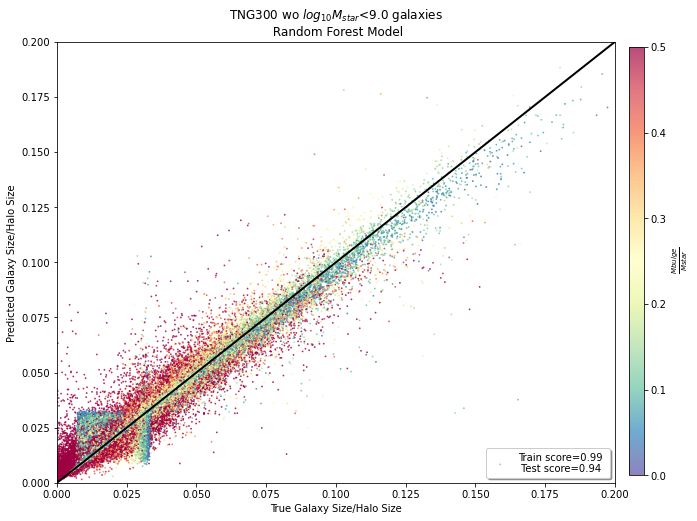

In [68]:
fig1, ax5 = plt.subplots(nrows=1,ncols=1, figsize=(10,7))

label = ('Train score=0.99 \n Test score=0.94')
im5 = ax5.scatter(df_normalized_35.loc[:, 'GalpropNormHalfRadius'], y_pred_RF, s=3, marker='.', alpha=0.7, label=label,
                 c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
ax5.axis([0.0,0.2, 0.0,0.2])
ax5.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax5.set_title(r'TNG300 wo $log_{10}M_{star}$<9.0 galaxies' + '\n Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
ax5.set_ylabel('Predicted Galaxy Size/Halo Size')
ax5.legend(loc='lower right', shadow=True)

cbar_ax = fig1.add_axes([0.92, 0.14, 0.02, 0.85])
fig1.colorbar(im5, cax=cbar_ax, label=r' $\frac{Mbulge}{Mstar}$')

fig1.subplots_adjust(top=1.0, hspace=2.0, wspace=0.03)
# fig1.tight_layout()
fig1.savefig("TNG300-SAM_images/v2_TNG300-SAM_pipeline_for_sizes/v2_TNG300-NewSAM_RF_size_prediction_35feat_MbulgeMstar.jpeg", dpi=500)
plt.show()

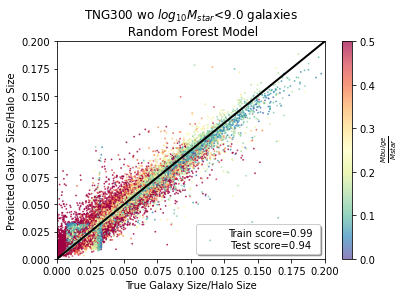

In [69]:

label = ('Train score=0.99 \n Test score=0.94')
plt.scatter(df_normalized_35.loc[:, 'GalpropNormHalfRadius'], y_pred_RF, s=3, marker='.', alpha=0.7, label=label,
                 c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
plt.axis([0.0,0.2, 0.0,0.2])
plt.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
plt.title(r'TNG300 wo $log_{10}M_{star}$<9.0 galaxies' + '\n Random Forest Model')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel('Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right', shadow=True)
plt.colorbar(label=r' $\frac{Mbulge}{Mstar}$')

# plt.savefig("TNG300-SAM_images/v2_TNG300-SAM_pipeline_for_sizes/v2_TNG300-NewSAM_RF_size_prediction_35feat_MbulgeMstar.jpeg", dpi=500)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


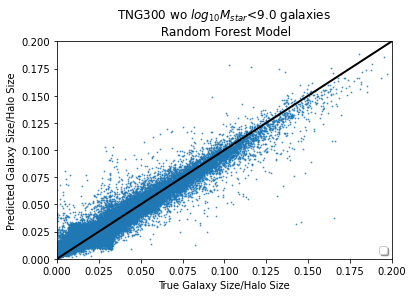

In [89]:

label = ('Train score=0.99 \n Test score=0.94')
plt.scatter(df_normalized_35.loc[:, 'GalpropNormHalfRadius'], y_pred_RF, s=3, marker='.', alpha=0.7) #, 
#             label=label, c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
plt.axis([0.0,0.2, 0.0,0.2])
plt.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
plt.title(r'TNG300 wo $log_{10}M_{star}$<9.0 galaxies' + '\n Random Forest Model')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel('Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right', shadow=True)
# plt.colorbar(label=r' $\frac{Mbulge}{Mstar}$')

# plt.savefig("TNG300-SAM_images/v2_TNG300-SAM_pipeline_for_sizes/v2_TNG300-NewSAM_RF_size_prediction_35feat_nocolorcode.jpeg", dpi=500)
plt.show()

In [72]:
mcold_size_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropNormMcold'], 
                                               df_normalized_35['GalpropNormHalfRadius'])[0], 2)
mcold_MHII_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropNormMcold'], 
                                              df_normalized_35['GalpropNormMHII'] )[0], 2)
mcold_MHI_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropNormMcold'], 
                                              df_normalized_35['GalpropNormMHI'] )[0], 2)
mcold_spin_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropNormMcold'], 
                                              df_normalized_35['HalopropSpin'] )[0], 2)
spin_size_corr_norm = round(stats.spearmanr(df_normalized_35['HalopropSpin'], 
                                              df_normalized_35['GalpropNormHalfRadius'])[0], 2)

MHI_MHII_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropNormMHI'], 
                                              df_normalized_35['GalpropNormMHII'] )[0], 2)
size_MHII_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropNormHalfRadius'], 
                                              df_normalized_35['GalpropNormMHII'] )[0], 2)
spin_MHII_corr_norm = round(stats.spearmanr(df_normalized_35['HalopropSpin'], 
                                              df_normalized_35['GalpropNormMHII'] )[0], 2)

print('mcold_size_corr_norm:', mcold_size_corr_norm)
print('mcold_MHII_corr_norm:', mcold_MHII_corr_norm)
print('mcold_MHI_corr_norm:', mcold_MHI_corr_norm)
print('mcold_spin_corr_norm:', mcold_spin_corr_norm)
print('spin_size_corr_norm:', spin_size_corr_norm)
print('MHI_MHII_corr_norm:', MHI_MHII_corr_norm)
print('size_MHII_corr_norm:', size_MHII_corr_norm)
print('spin_MHII_corr_norm:', spin_MHII_corr_norm)

mcold_size_corr_norm: 0.54
mcold_MHII_corr_norm: 0.96
mcold_MHI_corr_norm: 0.97
mcold_spin_corr_norm: 0.52
spin_size_corr_norm: 0.56
MHI_MHII_corr_norm: 0.97
size_MHII_corr_norm: 0.67
spin_MHII_corr_norm: 0.57


## <font color='darkviolet'>  <a id =4> </a> <br> Re-define dataset with by removing all galaxies with $f_{disk}$ < 0.02 after consulting with Rachel (keep the mass cut where all galaxies with $log_{10}M_{star}$ >9.0 are considered)

### <font color='red'> Conclusion: After consulting with Rachel, we remove all galaxies with $f_{disk}$ < 0.02 because MMW'98 $R_{disk}$ model is only good for galaxies with $f_{disk}$ > 0.02

### Normalized Dataset Redefined

In [13]:
df_normalized_wo_mstar9_wo_nonphysgals = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_wo_nonphys_gals.csv')


In [14]:
df_normalized_wo_mstar9_wo_nonphysgals.shape

(273385, 38)

In [15]:
# From the True Physical formula, fdisk is defined as below:
# mdisk = (mstar_disk + mass_cold_gas) Important Note: Use Mdisk (and NOT Mstar) here!!!
# fdisk = mdisk/m_halo
# In our normalized dataset, NormMstar=Mstar/Mhalo and NormMcold=Mcold/Mhalo, so fdisk = NormMstar + NormMcold
df_1 = df_normalized_wo_mstar9_wo_nonphysgals.loc[:, :]
df_1.loc[:, 'fdisk'] = df_1.loc[:, 'GalpropNormMdisk'] + df_1.loc[:, 'GalpropNormMcold']

In [16]:
df_1.shape

(273385, 39)

In [17]:
df_1_bigfdisk = df_1[df_1.fdisk>0.0205]
df_1_bigfdisk.shape

(172267, 39)

In [18]:
273385-172267

101118

In [19]:
(101118*100)/172267

58.69841583123872

#### <font color='red'> There are ~100,000 galaxies (101118; 59% of galaxies) with $f_{disk}$<0.0205 in the normalized dataset with $log_{10}M_{star}$>9.0 mass cut.

In [20]:
df_1_bigfdisk = df_1_bigfdisk.drop(columns=['fdisk'])
df_1_bigfdisk.shape

(172267, 38)

In [21]:
# Save Normalized Dataset without fdisk<0.02 and log10Mstar<9.0 galaxies
# df_1_bigfdisk.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_nonphys_and_smallfdsik_gals.csv', index=False)

### Raw Dataset Redefined

In [22]:
df_raw_wo_mstar9_wo_nonphysgals = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphysgals_wo_mstar9.csv')

In [23]:
df_raw_wo_mstar9_wo_nonphysgals.shape

(273385, 59)

In [24]:
df_2 = df_raw_wo_mstar9_wo_nonphysgals.loc[:, :]
df_2.loc[:, 'fdisk'] = (df_2.loc[:, 'GalpropMdisk'] + df_2.loc[:, 'GalpropMcold'])/df_2.loc[:, 'HalopropMvir']

In [25]:
df_2.shape

(273385, 60)

In [26]:
df_2_bigfdisk = df_2[df_2.fdisk>0.0205]
df_2_bigfdisk.shape

(172267, 60)

In [27]:
df_2_bigfdisk = df_2_bigfdisk.drop(columns=['fdisk'])
df_2_bigfdisk.shape

(172267, 59)

In [28]:
# Save Raw Dataset without fdisk<0.02 and log10Mstar<9.0 galaxies
# df_2_bigfdisk.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphys_mstar9_and_smallfdisk.csv', index=False)

### $f_{disk}$<0.02 histograms (note the spike in $f_{disk}$ still present)

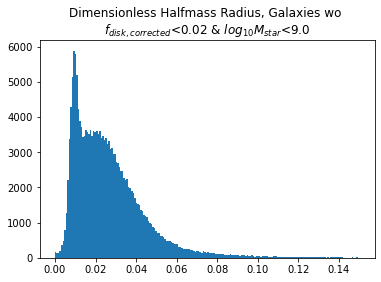

In [32]:
plt.hist(df_1_bigfdisk.GalpropNormHalfRadius, range=(0, 0.15), bins=200)
plt.title('Dimensionless Halfmass Radius, Galaxies wo \n'+r'$f_{disk,corrected}$<0.02 & $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/HalfmassRadius_hist_fdisk_corrected.jpeg', dpi=500)
plt.show()

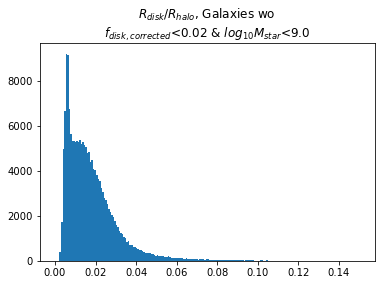

In [36]:
plt.hist(df_2_bigfdisk.GalpropRdisk/df_2_bigfdisk.GalpropRhalo, range=(0, 0.15), bins=200)
plt.title(r'$R_{disk}/R_{halo}$' +', Galaxies wo \n'+r'$f_{disk,corrected}$<0.02 & $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/RdiskRhalo_hist_fdisk_corrected.jpeg', dpi=500)
plt.show()

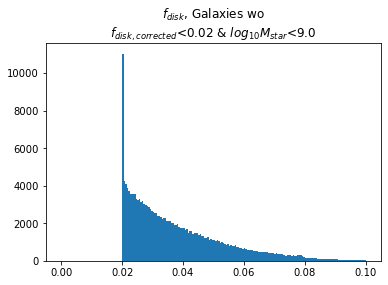

In [41]:
plt.hist(df_2[df_2.fdisk>0.02].fdisk, range=(0, 0.10), bins=200)
plt.title(r'$f_{disk}$' +', Galaxies wo \n'+r'$f_{disk,corrected}$<0.02 & $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/fdisk_hist_fdisk_corrected.jpeg', dpi=500)
plt.show()

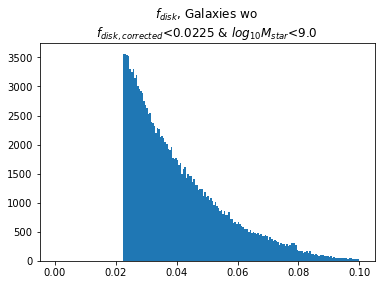

In [47]:
plt.hist(df_2[df_2.fdisk>0.0225].fdisk, range=(0, 0.10), bins=200)
plt.title(r'$f_{disk}$' +', Galaxies wo \n'+r'$f_{disk,corrected}$<0.0225 & $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/fdisk_hist_fdisk_corrected_00225.jpeg', dpi=500)
plt.show()

In [48]:
df_2[df_2.fdisk>0.0225].shape

(156274, 60)

In [52]:
df_2[(df_2.fdisk>0.0225) & (np.log10(df_2.GalpropMstar)<10.0)].shape

(95909, 60)

In [53]:
df_2[df_2.fdisk>0.0205].shape

(172267, 60)

### <font color='red'> We need to cut further to fdisk<0.0205 in order to remove the spike on fdisk. This causes another problem: there are less elliptical galaxies remaining!

In [32]:
df_2[(df_2.fdisk<0.0205) & (df_2.BulgeMstar_ratio<0.4)].shape

(65918, 60)

    There are 101,118 galaxies with fdisk<0.0205 (all morphologies). 
    There are 46,598 galaxies with fdisk<0.0205 and disk morphology (Mbulge/Mstar<0.2).
    There are 65,918 galaxies with fdisk<0.0205 and disk morphology (Mbulge/Mstar<0.4).
    That is, 35,200 galaxies among the one that we are cutting are elliptical galaxies.

# <font color='red'> Conclusion: The final dataset has 3 cuts, 1) remove all galaxies with $log_{10}M_{star}$<9.0, 2) all galaxies with $f_{disk}$<0.0205 and disk galaxies with $M_{bulge}/M_{star}$<0.4.

## <font color='darkviolet'>  <a id =5> </a> <br> Re-define dataset with by removing all galaxies with $f_{disk}$ < 0.02 and $M_{bulge}/M_{star}$<0.4  (keep the mass cut where all galaxies with $log_{10}M_{star}$ >9.0 are considered)

### Normalized Dataset Redefined

In [34]:
df_normalized_wo_mstar9_wo_nonphysgals = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_wo_nonphys_gals.csv')


In [35]:
df_normalized_wo_mstar9_wo_nonphysgals.shape

(273385, 38)

In [36]:
# From the True Physical formula, fdisk is defined as below:
# mdisk = (mstar_disk + mass_cold_gas) Important Note: Use Mdisk (and NOT Mstar) here!!!
# fdisk = mdisk/m_halo
# In our normalized dataset, NormMstar=Mstar/Mhalo and NormMcold=Mcold/Mhalo, so fdisk = NormMstar + NormMcold
df_3 = df_normalized_wo_mstar9_wo_nonphysgals.loc[:, :]
df_3.loc[:, 'fdisk'] = df_3.loc[:, 'GalpropNormMdisk'] + df_3.loc[:, 'GalpropNormMcold']

In [51]:
df_3.shape

(273385, 39)

In [50]:
# Choose all df_3, but remove (fdisk<0.0205 & Mbulge/Mstar<0.4) galaxies
df_3[~((df_3.fdisk<0.0205)&(df_3.BulgeMstar_ratio<0.4))]

GalpropMaccdot_radio  GalpropMstrip  GalpropMu_merger  \
1               1.829110e-01   5.522590e+13          0.454448   
2               3.029320e-04   2.700520e+12          0.112408   
3               2.649280e-03   3.956910e+12          0.371819   
5               1.523900e-05   6.546600e+11          0.125290   
7               1.743330e-07   1.060770e+11          0.345774   
...                      ...            ...               ...   
273376          2.920520e-08   1.427070e+11          0.146311   
273377          3.504890e-08   1.439620e+11          0.127838   
273379          5.540670e-08   1.490990e+11          0.123525   
273382          1.956600e-08   1.211400e+11          0.159240   
273384          1.163390e-08   8.245900e+10          0.745827   

        GalpropOutflowRate_Mass  GalpropOutflowRate_Metal  GalpropSfr  \
1                      0.058559                  0.102513    0.876171   
2                      0.089017                  0.095579    0.052143   
3                      0.060244                  0.128985    0.060710   
5                      0.525244                  0.207777    0.125328   
7                      2.062390                  0.279733    0.085121   
...                         ...                       ...         ...   
273376                 2.007480                  0.259787    0.129131   
273377                 2.070720                  0.271205    0.120232   
273379                 1.129170                  0.233719    0.080586   
273382                 1.055450                  0.196427    0.068833   
273384                 1.229060                  0.249970    0.033228   

        GalpropSfrave100myr  GalpropSfrave1gyr  GalpropSfrave20myr  \
1                  0.808964           0.939131            0.537264   
2                  0.048256           0.056811            0.031978   
3                  0.056173           0.065556            0.037231   
5                  0.116677           0.144474            0.076881   
7                  0.075566           0.084828            0.052104   
...                     ...                ...                 ...   
273376             0.120714           0.086515            0.079229   
273377             0.118064           0.073042            0.073942   
273379             0.074618           0.085615            0.049421   
273382             0.063072           0.077607            0.042193   
273384             0.030577           0.033394            0.020372   

        GalpropTmerger  GalpropTmerger_major  GalpropZcold  GalpropZstar  \
1              8.85112               8.85112     46.244400    172.628000   
2             10.84080             113.70200      2.884870      5.160050   
3             10.22880              10.22880      5.687560     59.120700   
5              9.95967              12.15330      1.405940      1.220240   
7              6.29965               6.29965      0.167850      0.434734   
...                ...                   ...           ...           ...   
273376        11.27350              11.43820      0.354625      0.212507   
273377        12.81030             113.70200      0.273724      0.215289   
273379         6.46847             113.70200      0.409495      0.322583   
273382        12.56810             113.70200      0.301455      0.282590   
273384         5.94891               5.94891      0.189627      3.401670   

        HalopropC_nfw  HalopropMaccdot_pristine  HalopropMaccdot_radio  \
1             9.98688                125.937000           1.829110e-01   
2             7.30021                  0.000000           3.029320e-04   
3            10.31160                  0.000000           2.649290e-03   
5            20.25370                  0.000000           1.523900e-05   
7            28.53360                  0.000000           1.743330e-07   
...               ...                       ...                    ...   
273376       21.22090                  0.344855           2.920520e-08   
2733

In [52]:
df_3[(df_3.fdisk<0.0205)&(df_3.BulgeMstar_ratio<0.4)].shape

(65918, 39)

In [39]:
273385-65918

207467

In [40]:
(65918*100)/273385

24.11178374819394

#### <font color='darkred'> There are ~66,000 galaxies (65,918; 24% of galaxies) with $f_{disk}$<0.0205 AND $M_{bulge}/M_{star}$<0.4 in the normalized dataset with $log_{10}M_{star}$>9.0 mass cut. Therefore, by imposing the morphology cut together with the low fdisk cut, we are removing 24% of available galaxies instead of 60%.

In [53]:
df_3_bigfdisk = df_3[~((df_3.fdisk<0.0205)&(df_3.BulgeMstar_ratio<0.4))]
df_3_bigfdisk.shape

(207467, 39)

In [54]:
df_3_bigfdisk = df_3_bigfdisk.drop(columns=['fdisk'])
df_3_bigfdisk.shape

(207467, 38)

In [55]:
# Save Normalized Dataset without (low fdisk, fdisk<0.0205 & disk galaxies, Mbulge/Mstar<0.4) and log10Mstar<9.0 galaxies
# df_3_bigfdisk.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_nonphys_and_diskgals_w_smallfdsik.csv', index=False)

### Raw Dataset Redefined

In [57]:
df_raw_wo_mstar9_wo_nonphysgals = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphysgals_wo_mstar9.csv')

In [58]:
df_raw_wo_mstar9_wo_nonphysgals.shape

(273385, 59)

In [59]:
df_4 = df_raw_wo_mstar9_wo_nonphysgals.loc[:, :]
df_4.loc[:, 'fdisk'] = (df_4.loc[:, 'GalpropMdisk'] + df_4.loc[:, 'GalpropMcold'])/df_4.loc[:, 'HalopropMvir']
df_4.shape

(273385, 60)

In [60]:
df_4_bigfdisk = df_4[~((df_4.fdisk<0.0205)&(df_4.BulgeMstar_ratio<0.4))]
df_4_bigfdisk.shape

(207467, 60)

In [61]:
df_4_bigfdisk = df_4_bigfdisk.drop(columns=['fdisk'])
df_4_bigfdisk.shape

(207467, 59)

In [62]:
# Save Raw Dataset without (low fdisk, fdisk<0.0205 & disk galaxies, Mbulge/Mstar<0.4) and log10Mstar<9.0 galaxies
# df_4_bigfdisk.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphys_mstar9_and_diskgals_w_smallfdisk.csv', index=False)

### Distribution Analysis

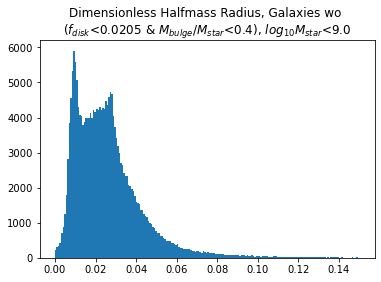

In [65]:
plt.hist(df_3_bigfdisk.GalpropNormHalfRadius, range=(0, 0.15), bins=200)
plt.title('Dimensionless Halfmass Radius, Galaxies wo \n'+r'($f_{disk}$<0.0205 & $M_{bulge}/M_{star}$<0.4), $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/HalfmassRadius_hist_fdisk_corrected.jpeg', dpi=500)
plt.show()

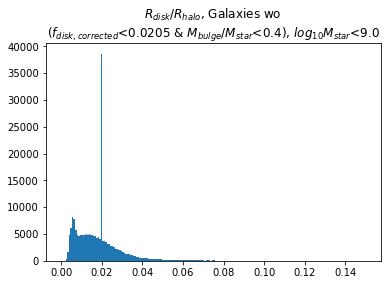

In [89]:
plt.hist(df_4_bigfdisk.GalpropRdisk/df_4_bigfdisk.GalpropRhalo, range=(0, 0.15), bins=200)
plt.title(r'$R_{disk}/R_{halo}$' +', Galaxies wo \n'+r'($f_{disk,corrected}$<0.0205 & $M_{bulge}/M_{star}$<0.4), $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/RdiskRhalo_hist_wo_DISKgals_w_smallfdisk.jpeg', dpi=500)
plt.show()

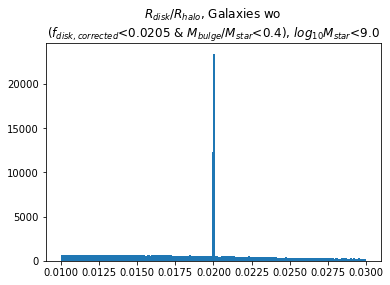

In [90]:
plt.hist(df_4_bigfdisk.GalpropRdisk/df_4_bigfdisk.GalpropRhalo, range=(0.01, 0.03), bins=200)
plt.title(r'$R_{disk}/R_{halo}$' +', Galaxies wo \n'+r'($f_{disk,corrected}$<0.0205 & $M_{bulge}/M_{star}$<0.4), $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/RdiskRhalo_hist_wo_DISKgals_w_smallfdisk_zoomed.jpeg', dpi=500)
plt.show()

In [88]:
df_4_bigfdisk[(df_4_bigfdisk.GalpropRdisk/df_4_bigfdisk.GalpropRhalo) == np.round(0.02, 2)].shape

(8573, 59)

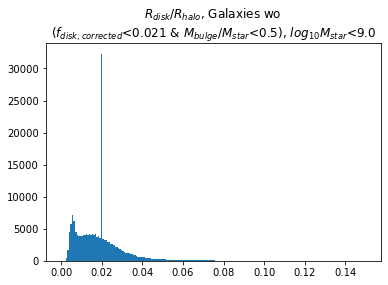

In [79]:
plt.hist(df_4[~((df_4.fdisk<0.023)&(df_4.BulgeMstar_ratio<0.5))].GalpropRdisk / df_4[~((df_4.fdisk<0.023)&(df_4.BulgeMstar_ratio<0.5))].GalpropRhalo,
        range=(0, 0.15), bins=200) 
plt.title(r'$R_{disk}/R_{halo}$' +', Galaxies wo \n'+r'($f_{disk,corrected}$<0.021 & $M_{bulge}/M_{star}$<0.5), $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/RdiskRhalo_hist_fdisk_corrected.jpeg', dpi=500)
plt.show()

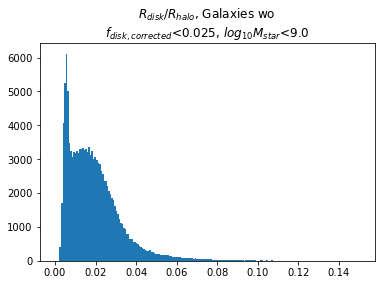

In [83]:
plt.hist(df_4[~(df_4.fdisk<0.026)].GalpropRdisk / df_4[~(df_4.fdisk<0.026)].GalpropRhalo,
        range=(0, 0.15), bins=200) 
plt.title(r'$R_{disk}/R_{halo}$' +', Galaxies wo \n'+r'$f_{disk,corrected}$<0.025, $log_{10}M_{star}$<9.0')
# plt.savefig('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/RdiskRhalo_hist_fdisk_corrected.jpeg', dpi=500)
plt.show()